In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from NPw_aux import prepare_ion_data
import warnings
import os
warnings.filterwarnings("ignore")
import logging
data_path = os.environ.get("DATA_PATH")
if data_path == None:
    raise KeyError("Enviromental variable data path has to be declared")
print(data_path)
from datetime import datetime, timedelta
freq = timedelta(minutes=30)
logging.disable(logging.CRITICAL)

/home/carloscano/data/


In [2]:
#df_GNSSTEC,df_covariates, df_eq = prepare_ion_data(datapath, "GRK", freq)

In [3]:
#df_GNSSTEC.to_pickle("df_GNSSTEC.pkl")
#df_covariates.to_pickle("df_covariates.pkl")
#df_eq.to_pickle("df_eq.pkl")

In [4]:
import pandas as pd
df_GNSSTEC = pd.read_pickle("../data_test/df_GNSSTEC.pkl")
df_covariates = pd.read_pickle("../data_test/df_covariate.pkl")
df_eq = pd.read_pickle("../data_test/df_eq.pkl")
n_forecasts = 48


In [5]:
%matplotlib inline
from aux_function_SR import read_data, get_eq_filtered, SR_SENSORS
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level, save, load
import logging
import pandas as pd

import pickle
from NPw import NPw, ConfigEQ, ConfigNPw, ConfigForecast
from dataclasses import dataclass, asdict
from dateutil.relativedelta import *

import ast

import sys
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler,MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

from NPw import NPw

import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from NPw_aux import prepare_EQ, ConfigEQ


In [6]:

ConfigEQ_d = {
    "dist_start": 100,
    "dist_delta": 30000,
    "mag_start": 6,
    "mag_delta": 1,
    "filter": 1,
    "drop": ["arc_cos", "arc_sin","depth",  "dist", "pr"],
}
config_events = ConfigEQ(**ConfigEQ_d)

df_input = df_GNSSTEC.reset_index()
df_other = df_covariates
df_events = prepare_EQ(df_eq, config_events)    
forecast_length = timedelta(hours=8)
question_mark_length = timedelta(hours=8)
# Time to take into account to predict 
historic_lenght =  timedelta(days=5)
training_lenght = timedelta(days=30)

In [7]:
synthetic_events = pd.DataFrame(np.array([0, 6, 6.5, 7, 7.5, 8]), columns= ["f107"])
synthetic_events

,f107
0,0.0
1,6.0
2,6.5
3,7.0
4,7.5
5,8.0


In [77]:
#synthetic_events = pd.read_pickle("../data_test/synthetic.pkl")
#df_synth = prepare_EQ(synthetic_events, config_events)  
output_path = "results/"

tag = "mag"
case = "trafic"
freq = pd.Timedelta(minutes=30)
if case == "TEC_constant":
    df_all = df_covariates[["f107"]]
    synthetic_events = df_covariates[["f107"]].quantile([.1,0.25, .5,0.75, .9])#.drop(["count", "std"])
    synthetic_events = pd.DataFrame(np.linspace(60, 80, 21), columns= ["f107"])
    synthetic_events = pd.DataFrame(np.arange(60, 85, 1), columns= ["f107"])
    df_covariates = df_covariates.drop("f107", axis = 1)
    config_synthetic = "constant"
elif case == "TEC_EQ": 
    config_synthetic = "constant"
    values = np.arange(0,16,3)
    synthetic_events = pd.DataFrame(values, columns= [tag])
    df_all = pd.DataFrame()
    for ix, eq in df_events.sort_values(by=[tag]).iterrows():
        event = pd.DataFrame(eq).T
        start_time = event.index[0]
        end_time = start_time + forecast_length - freq
        index = pd.date_range(start_time, end_time, freq = freq)
        df = pd.DataFrame(np.repeat(event.values, len(index)), columns = df_events.columns, index=index)
        df_all = df.combine_first(df_all)
elif case =="trafic":
    dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    df = pd.read_csv(data_path + "traffic/traffic_synthetic.csv", parse_dates=['ds'], date_parser=dateparse, index_col="ds")
    synthetic_events = pd.DataFrame([1], columns= ["ad"])
    df_all = df[["ad"]]
    df_covariates = df.drop(["ad", "traffic"], axis = 1)
    df_input=df[["traffic"]]
    freq = pd.Timedelta(hours=1)
elif case=="real_traffic":
    config_synthetic = "single"
    start_day = pd.Timestamp(year= 2016, month=4, day = 1)
    dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    infile = data_path + "traffic/metro-traffic-volume.test.csv"
    df = pd.read_csv(infile, parse_dates=['timestamp'], date_parser=dateparse)
    df = df.rename(columns={"is_anomaly": "ad", "timestamp": "ds", "traffic_volume": "traffic", "rain_1h": "rain", "snow_1h": "snow", "clouds_all": "clouds"}).set_index("ds")
    df = df[df.index > start_day]
    df = (df.reset_index()
            .drop_duplicates(subset='ds', keep='first')
            .set_index('ds').sort_index())
    df = df.resample('1H').mean().interpolate("from_derivatives")
    synthetic_events = pd.DataFrame([1], columns= ["ad"])
    df_all = df[["ad"]]
    df_covariates = df.drop(["ad", "traffic"], axis = 1)
    df_input=df[["traffic"]]
    freq = pd.Timedelta(hours=1)
elif case == "irradiance":
    config_synthetic = "single"
    start_day = pd.Timestamp(year= 2018, month=1, day = 1)
    path = data_path + "irradiance/POWER_Point_Hourly_20160101_20210101_040d4006N_003d6990W_LST.csv"
    df = pd.read_csv(path, parse_dates=["ds"]).set_index("ds").sort_index()
    df_all = df[["precipitation"]]
    df_all = df_all.loc[df_all["precipitation"] >0.5]
    df_input =  df[["Irradiance"]]
    df_covariates = df.drop(["Irradiance", "precipitation"], axis = 1)
    synthetic_events = pd.DataFrame(np.arange(0.5, 3.5, 0.5), columns = ["precipitation"])
    freq = pd.Timedelta(hours=1)
else:
    print(f"Not implemented")
    
 

In [80]:
df_all.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=ad<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'ad',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> ad <i style="color:#fc9944">~22h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'b049f82e-0264-4327-b50d-9a898a6f9060',
              'x': array([datetime.datetime(2016, 4, 1, 1, 0),
                          datetime.datetime(2016, 4, 1, 2, 0),
                          datetime.datetime(2016, 4, 1, 23, 0), ...,
                          datetime.datetime(2018, 9, 29, 3, 0),
                          datetime.datetime(2018, 9, 30, 1, 0),
                          datetime.datetime(2018, 9, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0., 0., 0., ..., 0., 0., 0.]),


In [71]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 1000
}


RNN_darts_FCeV_config = {
     "RNNmodel": "RNN"
}
RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

NBEATS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10
}


NHITS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10,
    "max_pool_1d": True
}

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 4,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 8,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)


NLinear_darts_FCeV_config = {
"const_init": True,
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)



NBEATS_darts_FCeV_config = NBEATSDartsFCeVConfig(**NBEATS_darts_FCeV_config)

NHITS_darts_FCeV_config = NHITSDartsFCeVConfig(**NHITS_darts_FCeV_config)


NLinear_darts_FCeV_config = NLinearDartsFCeVConfig(**NLinear_darts_FCeV_config)
 #assert self.head_dim * num_heads == self.embed_dim, 
Transformer_darts_FCeV_config = {
    #"d_model": 12,
    "n_head_divisor": 6,
    #"num_encoder_layers": 3,
    #"num_decoder_layers": 3,
    "dim_feedforward": 512
}
Transformer_darts_FCeV_config = TransformerDartsFCeVConfig(**Transformer_darts_FCeV_config)

darts_FCev_config = {
    "DartsModelConfig": RNN_darts_FCeV_config,
    "dropout":0.2,
    "n_epochs":200,
    "n_layers": 2,
    "internal_size": 16,
    "batch_size":1200 ,
    "learning_rate": 1e-1,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":25,
    "seed": 1234567,
    "probabilistic": True,
    "config_synthetic":config_synthetic
}
darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:

forecast_length = timedelta(hours=24)
question_mark_length = timedelta(hours=24)
# Time to take into account to predict 
historic_lenght =  timedelta(days=8)
training_lenght = timedelta(days=4000)


FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": True,
    "input_length": historic_lenght
}


FCev_config = FCeVConfig(**FCev_config)
current_fcev = FCeV(FCev_config, darts_FCeV_config, df_input, df_covariates,df_all,  output_path, synthetic_events)

In [73]:
import pandas_bokeh
import pandas as pd
pandas_bokeh.output_notebook()
pd.plotting.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
pd.options.plotting.backend = "plotly" 
df_all.plot()

Loading BokehJS ...

Loading BokehJS ...

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=ad<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'ad',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> ad <i style="color:#fc9944">~22h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '5c86d1b1-68de-4c0d-8837-e6b1dc18297f',
              'x': array([datetime.datetime(2016, 4, 1, 1, 0),
                          datetime.datetime(2016, 4, 1, 2, 0),
                          datetime.datetime(2016, 4, 1, 23, 0), ...,
                          datetime.datetime(2018, 9, 29, 3, 0),
                          datetime.datetime(2018, 9, 30, 1, 0),
                          datetime.datetime(2018, 9, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0., 0., 0., ..., 0., 0., 0.]),


In [74]:
max_interations = 12
current_fcev.create_folds(pd.Timestamp(2018,1,1, 12, 0), max_interations)

2016-04-01 01:00:00


In [75]:
current_fcev.folds

,start_date,end_date
0,2016-04-01 01:00:00,2018-01-22 11:00:00
1,2016-04-01 01:00:00,2018-02-12 10:00:00
2,2016-04-01 01:00:00,2018-03-05 09:00:00
3,2016-04-01 01:00:00,2018-03-26 08:00:00
4,2016-04-01 01:00:00,2018-04-16 07:00:00
5,2016-04-01 01:00:00,2018-05-07 06:00:00
6,2016-04-01 01:00:00,2018-05-28 05:00:00
7,2016-04-01 01:00:00,2018-06-18 04:00:00
8,2016-04-01 01:00:00,2018-07-09 03:00:00
9,2016-04-01 01:00:00,2018-07-30 02:00:00


In [76]:
current_fcev.FCeV_model.synthetic_events

{'EMPTY':      ad
 0   0.0
 1   0.0
 2   0.0
 3   0.0
 4   0.0
 5   0.0
 6   0.0
 7   0.0
 8   0.0
 9   0.0
 10  0.0
 11  0.0
 12  0.0
 13  0.0
 14  0.0
 15  0.0
 16  0.0
 17  0.0
 18  0.0
 19  0.0
 20  0.0
 21  0.0
 22  0.0
 23  0.0,
 '0-4':      ad
 0   0.0
 1   0.0
 2   0.0
 3   0.0
 4   1.0
 5   0.0
 6   0.0
 7   0.0
 8   0.0
 9   0.0
 10  0.0
 11  0.0
 12  0.0
 13  0.0
 14  0.0
 15  0.0
 16  0.0
 17  0.0
 18  0.0
 19  0.0
 20  0.0
 21  0.0
 22  0.0
 23  0.0,
 '0-8':      ad
 0   0.0
 1   0.0
 2   0.0
 3   0.0
 4   0.0
 5   0.0
 6   0.0
 7   0.0
 8   1.0
 9   0.0
 10  0.0
 11  0.0
 12  0.0
 13  0.0
 14  0.0
 15  0.0
 16  0.0
 17  0.0
 18  0.0
 19  0.0
 20  0.0
 21  0.0
 22  0.0
 23  0.0,
 '0-12':      ad
 0   0.0
 1   0.0
 2   0.0
 3   0.0
 4   0.0
 5   0.0
 6   0.0
 7   0.0
 8   0.0
 9   0.0
 10  0.0
 11  0.0
 12  1.0
 13  0.0
 14  0.0
 15  0.0
 16  0.0
 17  0.0
 18  0.0
 19  0.0
 20  0.0
 21  0.0
 22  0.0
 23  0.0,
 '0-16':      ad
 0   0.0
 1   0.0
 2   0.0
 3   0.0
 4   0.0
 5 

In [31]:
current_fcev.FCeV_model.synthetic_events.keys()

dict_keys(['0', '0-4', '0-8', '0-12', '0-16', '0-20', '1-4', '1-8', '1-12', '1-16', '1-20', '2-4', '2-8', '2-12', '2-16', '2-20', '3-4', '3-8', '3-12', '3-16', '3-20', '4-4', '4-8', '4-12', '4-16', '4-20', '5-4', '5-8', '5-12', '5-16', '5-20'])

In [32]:
df_fore = current_fcev.process_fold(0)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


KeyboardInterrupt



In [44]:
real = df_fore["current"].droplevel(0, 1)
pred = pd.DataFrame(df_fore["BASE"].mean(1))
pred.sub(real)

,0,traffic
ds,,
2018-01-21 11:00:00,NaN,NaN
2018-01-21 12:00:00,NaN,NaN
2018-01-21 13:00:00,NaN,NaN
2018-01-21 14:00:00,NaN,NaN
2018-01-21 15:00:00,NaN,NaN
2018-01-21 16:00:00,NaN,NaN
2018-01-21 17:00:00,NaN,NaN
2018-01-21 18:00:00,NaN,NaN
2018-01-21 19:00:00,NaN,NaN


In [37]:
df_fore["BASE"].mean(1).sub(real).plot()

TypeError: unsupported operand type(s) for -: 'float' and 'FigureWidgetResampler'

In [ ]:
iteration = 0
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore

In [43]:
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)
    #sys.exit(0)
    #Missing covariates; could not find past covariates in index value range: 2019-11-02 14:30:00 - 2019-11-04 14:00:00.

In [104]:
df.columns = df.columns.str.split("_", expand=True)
df.mean(level=0, axis = 1).sub(df_fore["current"]).pow(2).mean().pow(1/2).mean()

15.190336

In [142]:
df = df_fore_2["BASE"]
df.columns = df.columns.str.split("_", expand=True)
df.columns.nlevels 

[autoreload of DartsFCeV failed: Traceback (most recent call last):
  File "/home/carloscano/anaconda3/envs/neuralprophet/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/carloscano/anaconda3/envs/neuralprophet/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/carloscano/anaconda3/envs/neuralprophet/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/carloscano/dev/NeuralProphetEQ/notebooks/../DartsFCeV.py", l

1

In [46]:

synthetic_events

NameError: name 'data_path' is not defined

,precipitation
0,0.0
1,0.5
2,1.0
3,1.5
4,2.0
5,2.5
6,3.0


In [ ]:
df_fore["current"]

In [ ]:
df = df_fore["BASE"]
current = df_fore["current"].droplevel(0, 1)
for idx, group in df.groupby(level=0, axis = 1):
    #print(group.droplevel(0, axis = 1).head(40))
    print(group.droplevel(0, 1).head())
    print(current.head())
    print(group.droplevel(0, 1).sub(current).head(5))
    break

In [37]:
rmse_of_mean = df.mean(level=1, axis = 1).sub(df_fore["current"].droplevel(0, 1)).pow(2).mean().pow(1/2).mean()

In [ ]:
df = df_fore["BASE"].copy()

current = df_fore["current"].droplevel(0, 1)

mean_of_rmse = 0
for idx, group in df.groupby(level=0, axis = 1):
    mean_of_rmse = mean_of_rmse + group.droplevel(0, 1).sub(current).pow(2).mean().pow(1/2).mean() 
    print(mean_of_rmse)
mean_of_rmse =  ( mean_of_rmse /  len(df.groupby(level=0, axis = 1)))


print(f"mean of rmse {mean_of_rmse}")

In [64]:
from FCeV import METRICS
FCeV.get_metrics_from_fc(df_fore["current"],df_fore["BASE"], METRICS.RMSE)

77.38177947998047

In [ ]:
current_fcev.save_results(df_fore)

In [ ]:
df_main = df_fore["BASE"]
from FCeV import METRICS
current_ts = TimeSeries.from_dataframe(df_main["current"])
all_ts_base = current_fcev.FCeV_model.input_series.drop_after(current_ts.start_time())
all_ts_base = all_ts_base.append(current_ts)
all_ts_real, _ = current_fcev.FCeV_model.input_series.split_after(current_ts.end_time())

In [ ]:
df_main.head()

In [ ]:
from FCeV import METRICS
df_main = df_fore["EMPTY"]
print(current_fcev.get_metrics_from_fc(df_main["current"], df_main["pred"], METRICS.CoV).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [ ]:
df_main = df_fore["BASE"]
print(current_fcev.get_metrics_from_fc(df_main["current"], df_main["pred"], METRICS.CoV).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [ ]:
df_main = df_fore["2"]["2"]
print(current_fcev.get_metrics_from_fc(df_main["current"], df_main["pred"], METRICS.CoV).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [ ]:
df_main = df_fore["6"]["6"]
print(current_fcev.get_metrics_from_fc(df_main["current"], df_main["pred"], METRICS.CoV).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [ ]:
real = current_fcev.FCeV_model.input_series

In [ ]:
from FCeV import FCeVResultsData

In [ ]:
from pathlib import Path
result_config = list(Path("results/").rglob("*config.cpkl"))
value = next(gen, None)
if len(result_config) == 1:
    with open(result_config[0], 'rb') as f:
        x = pickle.load(f)
else:
    print(f"No config files: {len(result_config)}")

In [ ]:
iterations = current_fcev.iterations

In [ ]:
x.

In [ ]:
values = current_fcev.FCeV_model.model.predict(n=48, num_samples=1000).plot()


In [ ]:
day = iterations.iloc[iteration].end_date

In [ ]:
real.slice(day - pd.Timedelta(days = 4), day).plot()

## SALES EXAMPLE

In [ ]:
datapath_sales = "/home/carloscano/data/kaggle/store-sales-time-series-forecasting/"

In [ ]:
df_train =  pd.read_csv(datapath_sales + "train.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})
df_test =  pd.read_csv(datapath_sales + "test.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})


In [ ]:
df_test["ds"]

In [ ]:
df_train["family"].unique()

In [ ]:
df_train["store_nbr"].max()

#AUTOMOTIVE - 11

#Electronics index: 47 - 

import time
for i in range(1, 55):
    df_train_selected = df_train[(df_train["store_nbr"] == i) &(df_train["family"] == "BOOKS") ]
    df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("date")
    total_prom = np.sum(df_train_selected["onpromotion"] > 0)
    total_value = np.sum(df_train_selected["onpromotion"])
    print(f"index: {i} - {total_value} / {total_prom}")

In [ ]:
df_train_selected = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("ds")
df_signal = df_train_selected.drop("onpromotion", axis =1) #["sales"]
df_events = df_train_selected[df_train_selected["onpromotion"] > 0].drop("sales", axis = 1)
df_events["onpromotion"] = (df_events["onpromotion"] > 0)
df_events["onpromotion"] = 1

In [ ]:
df_cov1 = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "BREAD/BAKERY")) ]
df_cov1 = df_cov1.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")
df_cov2 = df_train[(df_train["store_nbr"] == 1) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_cov2= df_cov2.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")

df_covariates = pd.concat([df_cov1, df_cov2], axis = 1)
df_covariates.columns =  ["bread_54", "auto_1"]

In [ ]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 10
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)
RNN_darts_FCeV_config = {
     "RNNmodel": "GRU"
}

RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 6,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 2,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)



darts_FCev_config = {
    "DartsModelConfig": RNN_darts_FCeV_config,
    "dropout":0.1,
    "n_epochs":1000,
    "n_layers": 1,
    "internal_size": 28,
    "batch_size":600 ,
    "learning_rate": 1e-2,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":30,
    "seed": 1234567,
    "probabilistic": True
}

darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
forecast_length = timedelta(hours=24 * 3)
question_mark_length = timedelta(hours=24 * 3)
# Time to take into account to predict 
historic_lenght =  timedelta(days=32)
training_lenght = timedelta(days=798)
freq = pd.Timedelta(days=1)

FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": False,
    "input_length": historic_lenght
}

FCev_config = FCeVConfig(**FCev_config)

In [ ]:
df_synth = pd.DataFrame([1], columns = ["onpromotion"])

In [ ]:
os.getcwd()

In [ ]:
from scipy import stats
from scipy.optimize import minimize 

In [58]:
from pathlib import Path
all_pd = pd.DataFrame()
list_pandas = list()
for index_path in sorted(Path(output_path).rglob("*.pkl")):
    with open(index_path, 'rb') as f:
        x = pickle.load(f)
        list_pandas.append(x)
        

all_pd = pd.concat(list_pandas).sort_index()

In [35]:
from FCeV import METRICS, FCeVResultsData 
FCeV.get_metrics_from_fc(df["current"], df["BASE"], METRICS.CoV)

(24000, 100)


20.4094335436821

In [110]:
import datetime
from FCeV import METRICS, FCeVResultsData 
import FCeVResults
output_path = "/home/carloscano/outputs/irradiance//"
#current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)
df, FCeV_results_data = FCeVResults.read_result(output_path)
metric = METRICS.RMSE
FCeV_results_data["df_synthetics"]["EMPTY"] = FCeV_results_data["df_synthetics"].pop("0")
df.columns = df.columns.set_levels(['current', 'BASE', 'EMPTY', '0-4', '0-8', '0-12', '0-16', '0-20', '1-4','1-8', '1-12', '1-16', '1-20', '2-4', '2-8', '2-12', '2-16', '2-20','3-4', '3-8', '3-12', '3-16', '3-20', '4-4', '4-8', '4-12', '4-16','4-20', '5-4', '5-8', '5-12', '5-16', '5-20'], level=0)

In [275]:
import xarray as xr
observations = xr.DataArray(np.random.normal(size=(3,3)),
                            coords=[('x', np.arange(3)),
                                    ('y', np.arange(3))])
forecasts = xr.DataArray(np.random.normal(size=(3,3,3)),
                         coords=[('x', np.arange(3)),
                                 ('y', np.arange(3)),
                                 ('member', np.arange(3))])

In [382]:
LEN =48
import time
t0 = time.time()



df_real = df["current"].head(LEN)
df_real = df_real.droplevel(level = 0, axis = 1)
ds = df_real.to_xarray()
test_0 = df["BASE"].head(LEN)
df_score  = pd.melt(test_0, var_name='member', value_name='yhat', ignore_index=False)#.reset_index(drop=True)
df_score.set_index(["member"], append = True, inplace = True)
ds['yhat'] = df_score.to_xarray()['yhat']
a = ds.xs.crps_ensemble('Irradiance', 'yhat')

print(time.time() - t0)

0.006091117858886719


In [387]:
a.to_numpy()

array(6.58104876)

In [388]:
df_result = FCeVResults.get_results(df,FCeV_results_data, FCeVResults.SUMMARY_METRICS.CRPS, mean = False)

Duration: 140.91372156143188


In [389]:

df_result.columns = df_result.columns.str.split("-", expand=True)
df_result = df_result.min(level=0, axis = 1)

In [390]:
df_result

,0,1,2,3,4,5,EMPTY,current
2017-12-31 11:30:00,5.365591,5.473310,5.417195,4.975432,4.753762,4.819943,6.335884,0.00
2018-01-01 11:30:00,6.998769,7.621948,7.616532,7.811511,8.177253,7.609101,6.888841,0.00
2018-01-02 11:30:00,8.576941,8.444267,8.451069,7.971096,7.987506,8.020307,9.805609,0.00
2018-01-03 11:30:00,19.495258,19.523799,19.241994,18.842270,18.623071,18.248365,21.067372,3.04
2018-01-04 11:30:00,10.066502,10.215059,10.403499,10.354170,9.362926,9.599444,11.827454,0.00
...,...,...,...,...,...,...,...,...
2020-09-21 11:30:00,4.379672,4.435715,4.480616,4.594800,4.473112,4.633899,4.346497,0.00
2020-09-22 11:30:00,4.172054,4.257427,4.444913,4.556729,4.322840,4.315073,4.567943,0.00
2020-09-23 11:30:00,11.128777,11.177836,10.958818,10.287309,10.108098,9.997103,12.768672,0.00
2020-09-24 11:30:00,16.469145,16.853124,17.245895,16.511546,16.102341,17.508641,18.402972,0.82


In [430]:
df_violin = df_result.copy()

column = df_violin.pop("EMPTY")
df_violin.insert(0, "EMPTY", column)

In [431]:
df_violin = df_violin.drop("current", 1)

In [432]:
df_violin = pd.DataFrame((df_violin.T.values - df_violin.mean(1).values) / df_violin.std(1).values, index = df_violin.columns).T
df_violin["class"] = (df_result["current"]  > 0.5).values

In [433]:
sns.set(rc={'figure.figsize':(20,8.27)})


In [434]:
df_violin

,EMPTY,0,1,2,3,4,5,class
0,1.904455,0.110416,0.309585,0.205829,-0.610977,-1.020838,-0.898470,False
1,-1.430024,-1.185604,0.200009,0.187968,0.621496,1.434708,0.171445,False
2,2.084788,0.173714,-0.032647,-0.022067,-0.768619,-0.743094,-0.692075,False
3,1.947378,0.223210,0.254512,-0.054550,-0.492934,-0.733335,-1.144281,True
4,1.976606,-0.245840,-0.058352,0.179474,0.117216,-1.133803,-0.835301,False
...,...,...,...,...,...,...,...,...
995,-1.244702,-0.930113,-0.398682,0.027091,1.109852,-0.044059,1.480613,False
996,1.268124,-1.357152,-0.791014,0.452268,1.193758,-0.357236,-0.408748,False
997,1.943438,0.221261,0.272781,0.042774,-0.662428,-0.850631,-0.967195,False
998,1.785539,-0.699309,-0.205920,0.298767,-0.644826,-1.170630,0.636379,True


<AxesSubplot: xlabel='Hyphotesis', ylabel='metric'>

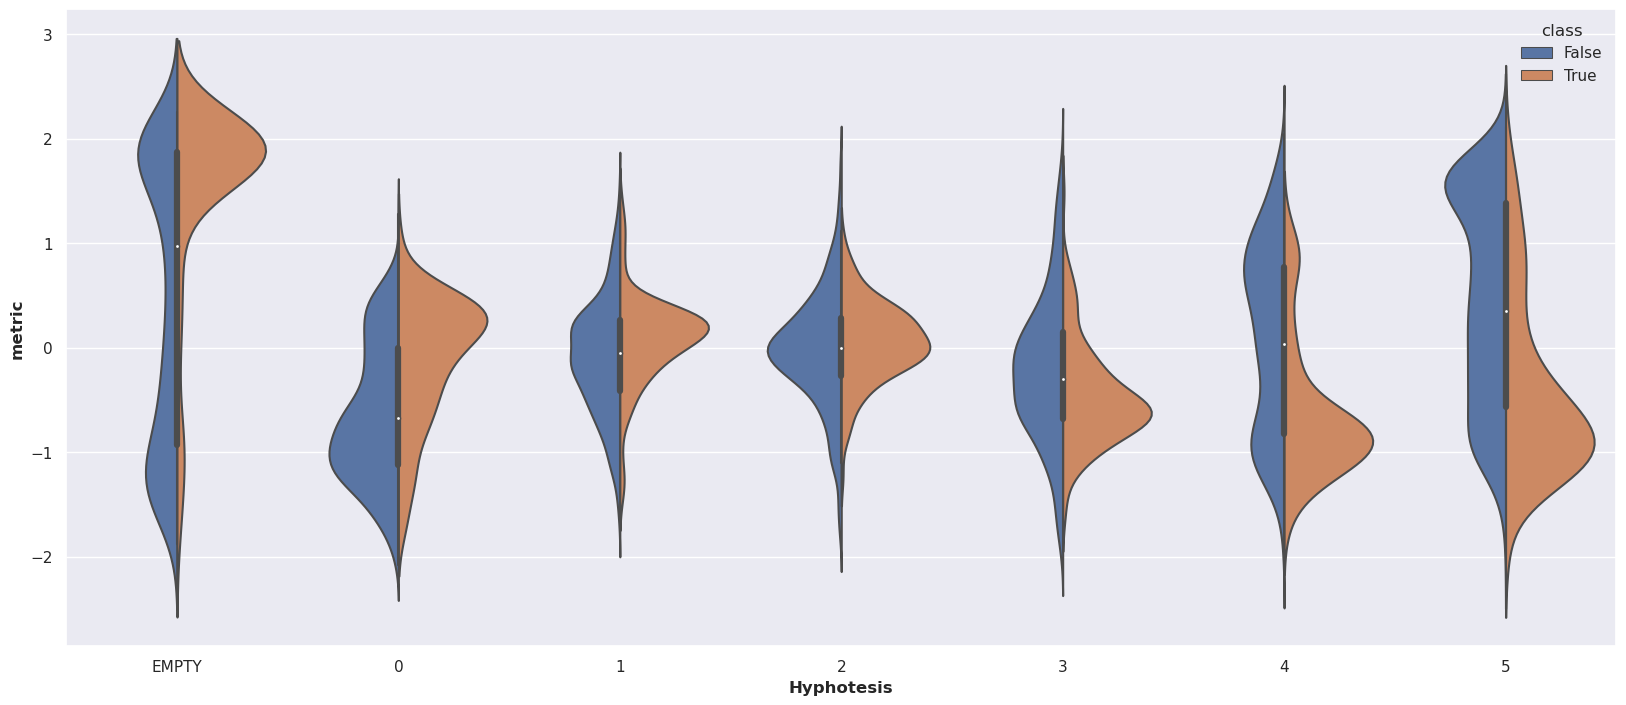

In [435]:

df_violin = pd.melt(df_violin, id_vars="class",var_name='Hyphotesis', value_name='metric')
sns.violinplot(data=df_violin, x = "Hyphotesis", y="metric", hue = "class", split=True)

In [400]:
discarted_columns = ["EMPTY", "0", "1", "2", "3"]
df_compress = df_result.copy()

df_compress = df_compress.drop("current", 1)
df_compress = (df_compress["EMPTY"].values - df_compress.drop(["EMPTY"], 1).T.values) / df_compress["EMPTY"].values
df_compress = df_compress - np.min(df_compress) / (np.max(df_compress) - np.min(df_compress))
df_compress = pd.DataFrame(df_compress).T

df_compress["class"] = (df_result["current"]  > 0.5).values
df_compress.head()
df_compress_violin = pd.melt(df_compress, id_vars="class",var_name='type', value_name='rmse')

<AxesSubplot: xlabel='type', ylabel='rmse'>

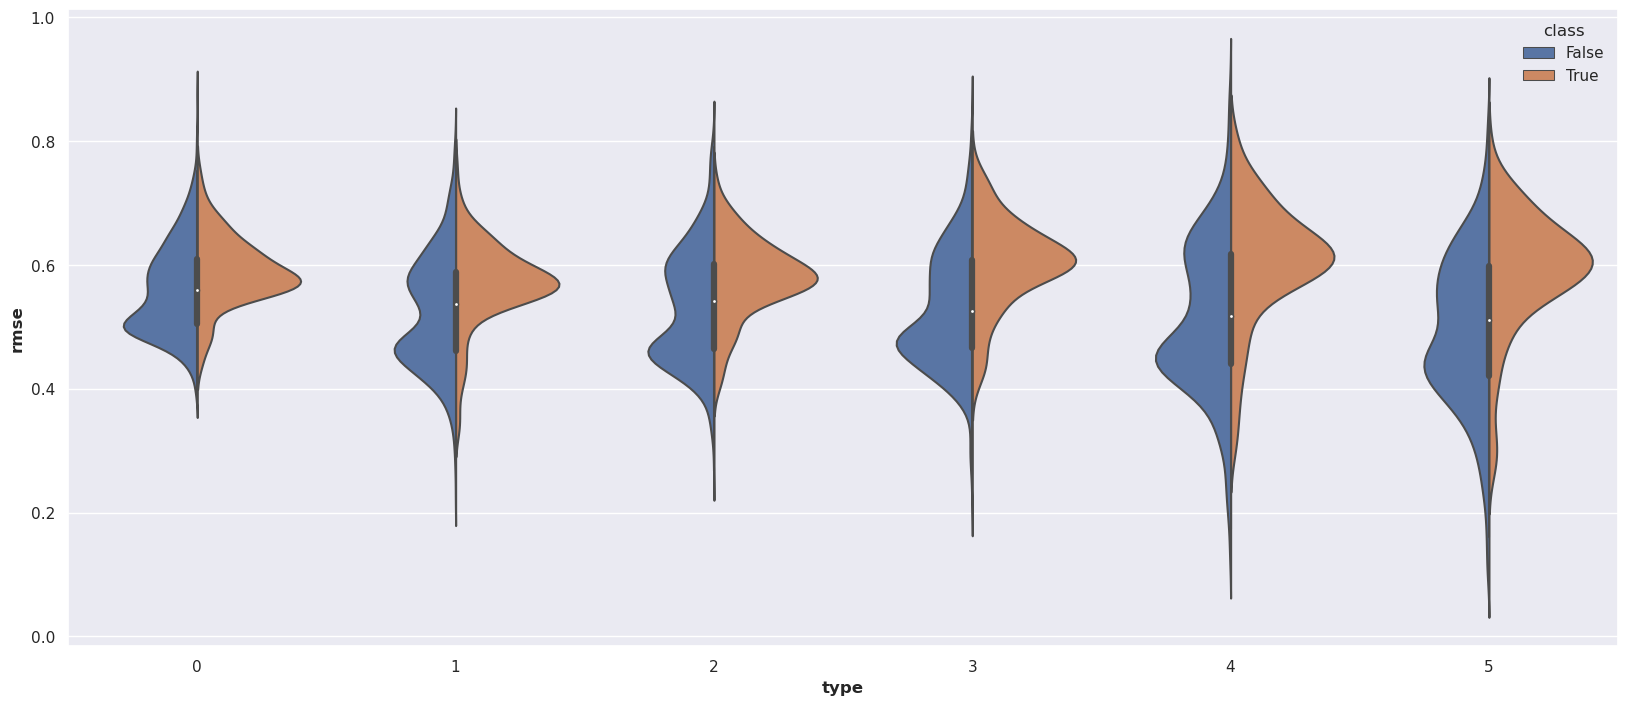

In [204]:
sns.violinplot(data=df_compress_violin, x = "type", y="rmse", hue = "class", split=True)

In [199]:

df_selected = df_result_pure.drop(discarted_columns, axis = 1)

In [440]:
import itertools
discarted_columns = ["EMPTY", "0", "1", "2", "3"]
df_result_pure = df_result.drop("current", 1)
df_selected = df_result_pure.drop(discarted_columns, axis = 1)
df_compress = (df_result_pure[discarted_columns].min(1).values - df_result_pure.drop(discarted_columns, axis = 1).T.values) / df_result_pure[discarted_columns].min(1).values
df_compress = df_compress - np.min(df_compress) / (np.max(df_compress) - np.min(df_compress))
df_compress = pd.DataFrame(df_compress).T
thresshold = 0.1
sensitivity_list = list()
specificity_list = list()
roc = np.array([])
for thresshold in  np.linspace(0,1,100):
    pred =  df_compress.apply(lambda x: 1 if  (x.argmax() >= 0) and (x.max() > thresshold) else 0, 1)
    minimum = df_compress.apply(lambda x: x.min(), 1)
    df_completed = pd.DataFrame()

    df_completed["pred"] = pred
    #df_completed["selected"] = selected
    #df_completed["minimum"] = minimum
    current = df_result["current"] >0.5
    df_completed["current"] = current
    import sklearn
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(current, pred).ravel()
    total1= tn + fp + fn + tp #sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(tn+tp)/total1
    #rint ('Accuracy : ', accuracy1)

    sensitivity1 = tn/(tn+fp)
    #rint('Sensitivity : ', sensitivity1 )

    specificity1 = tp/(fn+tp)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    #rint('Specificity : ', specificity1)
    sensitivity_list.append(sensitivity1)
    specificity_list.append(specificity1)
    roc = np.append(roc, [fpr, tpr])
roc = roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

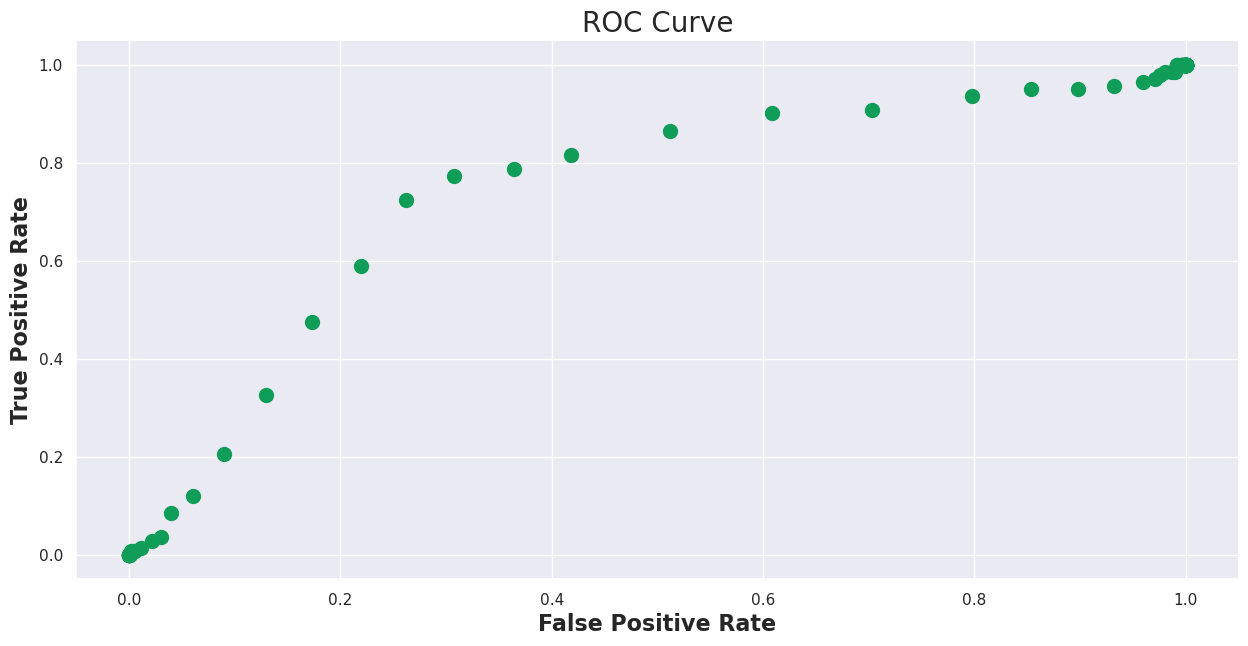

In [441]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
plt.figure(figsize=(15,7))
plt.scatter(roc[:,0],roc[:,1],color='#0F9D58',s=100)
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [16]:
roc_curve(np.array(sensitivity_list), np.array(specificity_list))

ValueError: continuous format is not supported

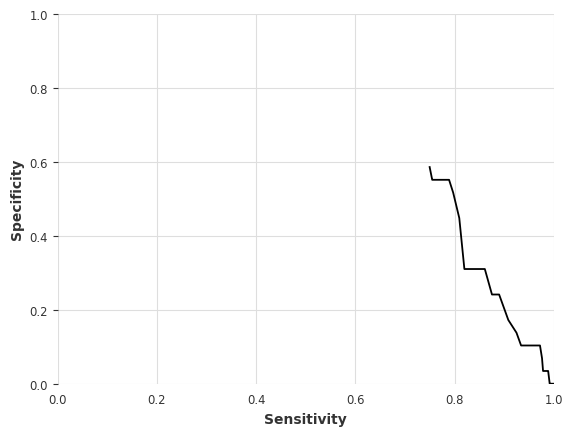

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.array(sensitivity_list), np.array(specificity_list))
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


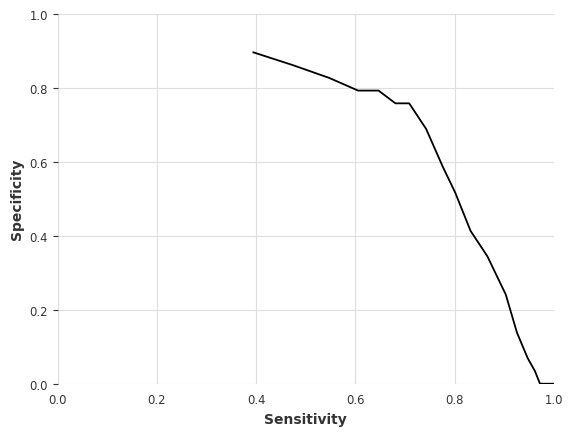

In [137]:
import matplotlib.pyplot as plt
plt.plot(np.array(sensitivity_list), np.array(specificity_list))
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


In [17]:
df_compress.reset_index().head()

,index,0,1,2,3,4,5
0,2017-12-31 11:30:00,0.089720,0.065982,0.084345,0.107577,0.135155,0.118257
1,2018-01-01 11:30:00,-0.028100,-0.066664,-0.049860,-0.066296,-0.077197,-0.070646
2,2018-01-02 11:30:00,0.080964,0.065833,0.075349,0.092852,0.104402,0.087514
3,2018-01-03 11:30:00,0.058883,0.050016,0.071868,0.089705,0.100205,0.107708
4,2018-01-04 11:30:00,0.077453,0.066949,0.063724,0.053196,0.094084,0.072682


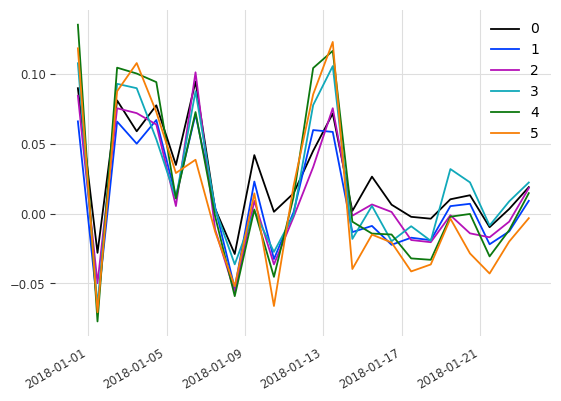

In [19]:
dfm = df_compress.head(24).reset_index().melt('index', var_name='cols', value_name='vals')
ax = df_compress.head(24).plot.line( legend=True)


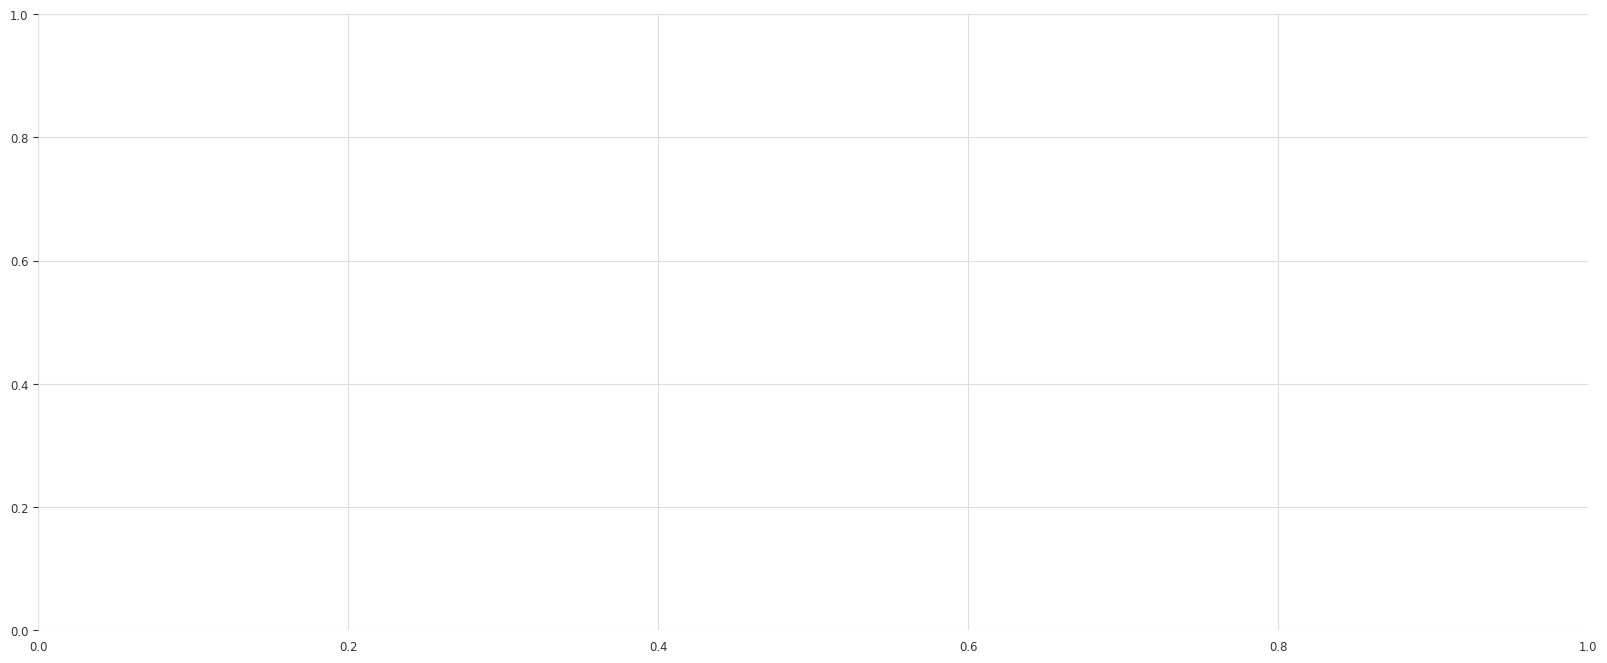

In [300]:
COLOR_TEMPERATURE = "#69b3a2"
COLOR_PRICE = "#3399e6"

fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()
ax1.plot(date, temperature, color=COLOR_TEMPERATURE, lw=3)
ax2.plot(date, price, color=COLOR_PRICE, lw=4)

ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (Celsius °)", color=COLOR_TEMPERATURE, fontsize=14)

In [ ]:
pd.options.plotting.backend = 'matplotlib'
ax = dfm.plot(x='index', y='vals', color='blue', legend=False)
sec_axis = ax.twinx()
df_compress[["current"]].plot(x='ds', y='current', ax=sec_axis, color='red', legend=False)
ax.figure.legend()
plt.show()

In [46]:
df_current = df["current"]
current = df_current.droplevel(0, 1)
df_pred = df["BASE"]
num_components = len(df_pred.columns.levels[1])
from FCeV import FCeV, METRICS
group = pd.DataFrame(df_pred).values

current = np.tile(current, group.shape[1] // num_components)
np.mean(np.divide(np.power(np.mean(np.power(np.subtract(group,current),2),0),1/2), np.mean(current,0)))
x = np.median(np.divide(np.power(np.mean(np.power(np.subtract(group,current),2),0),1/2), np.mean(current,0)))
print(x.shape)

()


In [91]:
pd.options.plotting.backend = "plotly" 
#df_completed.plot()


array([[808, 109],
       [ 46,  37]])

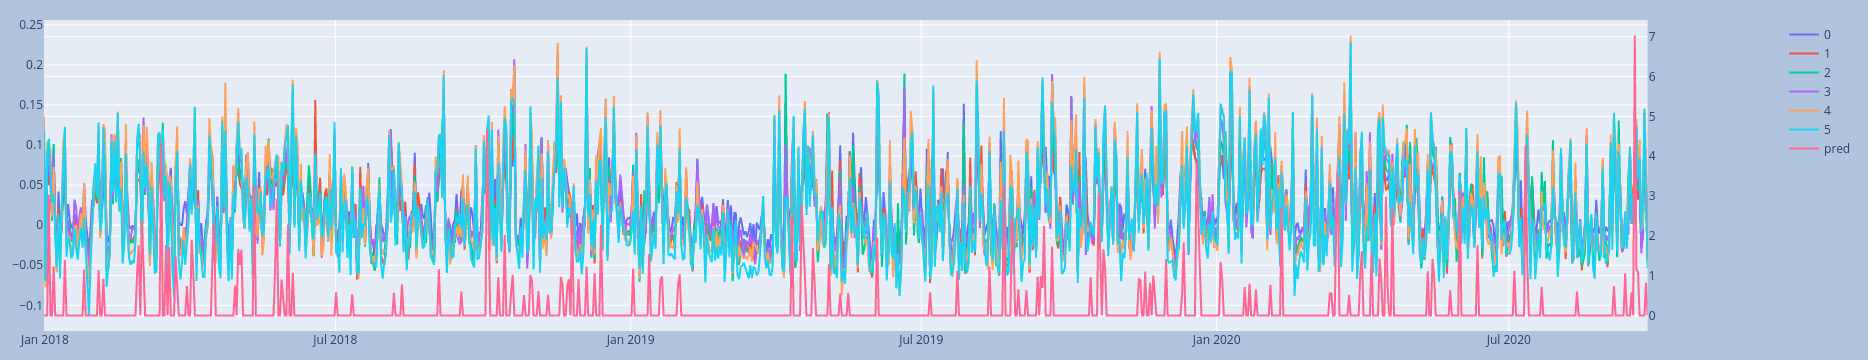

In [31]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

for column in df_compress.columns:
    current_y = df_compress[column].rolling(1).mean() #[df_compress[column] > 0.1]
    fig.add_trace(
        go.Scatter(x=current_y.index, y=current_y, name=str(column)), #, mode="markers"
        secondary_y=False,
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.add_trace(
    go.Scatter(x=df_compress.index, y=df_result["current"], name=str("pred")),
    secondary_y=True,)

fig.show()

In [297]:
sec_axis = ax.twinx()
df_compress[["current"]].plot(x='ds', y='current', ax=sec_axis, color='red', legend=False)
plt.show()

KeyError: "None of [Index(['current'], dtype='object')] are in the [columns]"

In [269]:

import matplotlib.pyplot as plt
df_compress = (( df_result[["EMPTY"]].values - df_result.drop(["current", "EMPTY"], axis = 1) ) / df_result[["EMPTY"]].values)
ax = df_compress.plot()
ax = df_compress.plot(x='ds', y='5', color='blue')

df_compress[["current"]].plot(x='ds', y='current', ax=sec_axis, color='red', legend=False)
ax.figure.legend()
plt.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['0', '1', '2', '3', '4', '5'] but received: ds

In [ ]:
plot = (ggplot(current_forecast.reset_index()) +  # What data to use
         aes(x="ds", color = "component", fill = "component")  # What variable to use
        + geom_ribbon(aes(y = "pred", ymin = "uncer_min", ymax = "uncer_max"), alpha = .2, color = 'none') #
        + geom_line(aes(y="current"),size = 1.5)  # Geometric object to use for drawing 
        + geom_line(aes(y="pred"),linetype="dashed",size = 1.5 )  # Geometric object to use for drawing 
        + theme_minimal() 
        +theme(legend_position="bottom", figure_size=(15, 6))
        + scale_color_brewer(type="qual", palette="Set1")
            )

In [ ]:
FCeV_results_data

In [9]:
input_length = FCeV_results_data["n_forecast"]
df_events = FCeV_results_data["df_events"]
df_input = FCeV_results_data["df_input"]
freq = FCeV_results_data["freq"]
index_synth = list(FCeV_results_data["df_synthetics"].keys())
values_synth = [value.max().values[0] for value in FCeV_results_data["df_synthetics"].values()]
CF_events = pd.DataFrame(values_synth, index = index_synth, columns = ["CF"])

In [11]:
remove_columns = df.columns.levels[0][np.logical_not(list_columns)]
df_current_base = df["current"].sort_index()
df_pred = df.drop(remove_columns, axis = 1, level = 0)
df_current_base = df_current_base.loc[df_pred.index].values
#df_current_base = np.tile(df_current_base, len(df_pred.columns.levels[1]) - 1)
num_components = len(df_pred.columns.levels[2])
expected = FCeV_results_data["df_events"].loc[df_pred.index]
df_results = pd.DataFrame()
list_result = list()
input_length = 48
start = time.time()
for index in range(len(df_pred) // input_length):
    index_selected = np.arange(index * input_length, (index + 1) * input_length )
    df_test = df_pred.iloc[index_selected]
    
    start_index = df_test.index.mean().round(freq='s')
    dict_values = {}
    
    for idx_CF, group_CF in df_test.groupby(level=0, axis = 1):
        #group_CF = group_CF.mean(axis = 1,level=2)
        df_current = df_current_base[index_selected,:]
        df_current = np.tile(df_current, group_CF.shape[1] // num_components)
        #dict_values[idx_CF] = np.mean(np.power(np.mean(np.power(np.subtract(new_pred,df_current),2),0),1/2))
        dict_values[idx_CF] = np.mean(np.divide(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2), np.mean(df_current,0)))
        #dict_values[idx_CF] = np.mean(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2))
        # RMSE 2
        #dict_values[idx_CF] = np.mean(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2))
        #dict_values[idx_CF] = np.mean(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2))
        #current_group = group_CF.droplevel(0, 1)
        #dict_values[idx_CF] = FCeV.get_metrics_from_fc(df_current, group_CF, METRICS.CoV)
    result = pd.DataFrame(dict_values,  index = [group_CF.index.mean()])
    mean_non_zero = np.mean(result.values[0][1:]) 
    diff =  mean_non_zero - result.values[0][0]
    result["pred"] = CF_events.loc[result.columns[np.argmin(result)]][0]
    result["current"] = np.mean(expected.iloc[index_selected])[0] 
    result["mean_non_zero"] = mean_non_zero
    result["diff"] = diff
    
    list_result.append(result)
print(f"Duration: {time.time()-start}")   
df_result = pd.concat(list_result)

NameError: name 'list_columns' is not defined

In [12]:
current = df_result["current"] > 6
pred  = df_result["pred"] > 6
import sklearn
sklearn.metrics.confusion_matrix(current, pred)

NameError: name 'df_result' is not defined

In [13]:
df.columns.levels[0]

Index(['current', 'BASE', '0', '0-4', '0-8', '0-12', '0-16', '0-20', '1-4',
       '1-8', '1-12', '1-16', '1-20', '2-4', '2-8', '2-12', '2-16', '2-20',
       '3-4', '3-8', '3-12', '3-16', '3-20', '4-4', '4-8', '4-12', '4-16',
       '4-20', '5-4', '5-8', '5-12', '5-16', '5-20'],
      dtype='object')

['EMPTY',
 '0-4',
 '0-8',
 '0-12',
 '0-16',
 '0-20',
 '1-4',
 '1-8',
 '1-12',
 '1-16',
 '1-20',
 '2-4',
 '2-8',
 '2-12',
 '2-16',
 '2-20',
 '3-4',
 '3-8',
 '3-12',
 '3-16',
 '3-20',
 '4-4',
 '4-8',
 '4-12',
 '4-16',
 '4-20',
 '5-4',
 '5-8',
 '5-12',
 '5-16',
 '5-20']

In [240]:
df.columns.levels[0]
FCeV_results_data["df_synthetics"]["EMPTY"] = FCeV_results_data["df_synthetics"].pop("0")

KeyError: '0'

In [15]:
list_columns = [True if value in FCeV_results_data["df_synthetics"].keys() else False for value in df.columns.levels[0]]

In [16]:
CF_events = pd.DataFrame(values_synth, index = index_synth, columns = ["CF"])
#CF_events = CF_events.loc[["0", "0-16", "1-16", "2-16", "3-16", "4-16", "5-16"]]
list_columns = [True if value in CF_events.index else False for value in df.columns.levels[0]]

In [18]:
df_pred.columns.levels[0].str.split("-", expand=True)

NameError: name 'df_pred' is not defined

In [228]:
import FCeVResults
df.columns = df.columns.set_levels(['current', 'BASE', 'EMPTY', '0-4', '0-8', '0-12', '0-16', '0-20', '1-4','1-8', '1-12', '1-16', '1-20', '2-4', '2-8', '2-12', '2-16', '2-20','3-4', '3-8', '3-12', '3-16', '3-20', '4-4', '4-8', '4-12', '4-16','4-20', '5-4', '5-8', '5-12', '5-16', '5-20'], level=0)

FCeVResults.get_results(df,FCeV_results_data, FCeVResults.SUMMARY_METRICS.CoV)

Duration: 20.07911777496338


,0-12,0-16,0-20,0-4,0-8,1-12,1-16,1-20,1-4,1-8,...,4-16,4-20,4-4,4-8,5-12,5-16,5-20,5-4,5-8,current
2017-12-31 11:30:00,0.289319,0.314443,0.314697,0.327106,0.317308,0.296864,0.309276,0.308144,0.317767,0.308772,...,0.299495,0.314750,0.306546,0.306168,0.280249,0.314399,0.310082,0.310978,0.316215,0.00
2018-01-01 11:30:00,0.183316,0.174563,0.179395,0.177505,0.177724,0.181507,0.181299,0.182074,0.181111,0.188965,...,0.187487,0.185855,0.182899,0.206817,0.210387,0.181787,0.185140,0.188711,0.210174,0.00
2018-01-02 11:30:00,0.274651,0.294745,0.293131,0.300819,0.292691,0.279173,0.284684,0.286212,0.293706,0.282591,...,0.281237,0.293263,0.286727,0.267646,0.274127,0.292704,0.288430,0.287758,0.272693,0.00
2018-01-03 11:30:00,0.588859,0.618977,0.618230,0.626897,0.619515,0.594407,0.606576,0.608709,0.618247,0.601518,...,0.592883,0.614652,0.610136,0.585424,0.558309,0.609192,0.610469,0.609110,0.589019,3.04
2018-01-04 11:30:00,0.136293,0.147684,0.146810,0.150865,0.145099,0.142122,0.137845,0.141791,0.146791,0.141439,...,0.135734,0.144855,0.143171,0.133836,0.147183,0.144528,0.140733,0.142479,0.136998,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21 11:30:00,0.075634,0.073744,0.073661,0.076280,0.072964,0.076155,0.075520,0.074271,0.074425,0.079162,...,0.078692,0.074091,0.072578,0.086028,0.090727,0.078889,0.072806,0.075212,0.089657,0.00
2020-09-22 11:30:00,0.069914,0.069285,0.067275,0.071393,0.068779,0.073600,0.068321,0.068566,0.069228,0.072052,...,0.070049,0.069250,0.068554,0.083532,0.103760,0.071861,0.066820,0.070638,0.089925,0.00
2020-09-23 11:30:00,0.158784,0.173686,0.172355,0.176595,0.171991,0.161454,0.168201,0.168477,0.172793,0.163017,...,0.162754,0.171705,0.170748,0.155059,0.149187,0.170919,0.169981,0.169237,0.157162,0.00
2020-09-24 11:30:00,0.349515,0.371539,0.366684,0.382329,0.368213,0.361157,0.353529,0.361309,0.369707,0.363429,...,0.357442,0.372619,0.357555,0.344442,0.367796,0.373294,0.362430,0.359953,0.361622,0.82


In [19]:
df_pred = df.drop(remove_columns, axis = 1, level = 0)
df_pred.columns.levels[0]

NameError: name 'remove_columns' is not defined

In [220]:
import time
from FCeVResults import SUMMARY_METRICS
metric = SUMMARY_METRICS.CoV
remove_columns = df.columns.levels[0][np.logical_not(list_columns)]
df_current_base = df["current"].sort_index()
df_pred = df.drop(remove_columns, axis = 1, level = 0)
df_current_base = df_current_base.loc[df_pred.index].values
#df_current_base = np.tile(df_current_base, len(df_pred.columns.levels[1]) - 1)
num_components = len(df_pred.columns.levels[2])
expected = FCeV_results_data["df_events"].loc[df_pred.index]
df_results = pd.DataFrame()
list_result = list()
start = time.time()
for index in range(len(df_pred) // input_length):
    index_selected = np.arange(index * input_length, (index + 1) * input_length )
    df_test = df_pred.iloc[index_selected]
    
    start_index = df_test.index.mean().round(freq='s')
    dict_values = {}
    
    for idx_CF, group_CF in df_test.groupby(level=0, axis = 1):
        df_current = df_current_base[index_selected,:]

        if metric == SUMMARY_METRICS.CoV:
            df_current = np.tile(df_current, group_CF.shape[1] // num_components)
            dict_values[idx_CF] = np.mean(np.divide(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2), np.mean(df_current,0)))
        elif metric == SUMMARY_METRICS.RMSE:
            df_current = np.tile(df_current, group_CF.shape[1] // num_components)
            dict_values[idx_CF] = np.mean(np.power(np.mean(np.power(np.subtract(group_CF,df_current),2),0),1/2))
        elif metric is SUMMARY_METRICS.ZSCORE:
            group_CF = group_CF.mean(axis = 1,level=2)
            df_current = df_current_base[index_selected,:]
        elif metric is SUMMARY_METRICS.CosSim:
            df_current = np.tile(df_current, group_CF.shape[1] // num_components)
            dict_values[idx_CF]  = 1 - np.mean(np.diag(cosine_similarity(np.transpose(df_current), np.transpose(group_CF))))
        elif metric is SUMMARY_METRICS.DTW:
            import dtaidistance
        elif metric is SUMMARY_METRICS.PRESS:
            dict_values[idx_CF] =  np.mean(np.sum(np.power(np.subtract(df_current,group_CF), 2),0))
            
    result = pd.DataFrame(dict_values,  index = [group_CF.index.mean()])

    #result["pred"] = result["diff"] > 20
    result["current"] = np.max(expected.iloc[index_selected])[0]  
    list_result.append(result)
print(f"Duration: {time.time()-start}")   


Duration: 21.189595460891724


In [ ]:
import dtaidistance
current.combine(pred, lambda x, y: np.repeat(dtaidistance.dtw.distance_fast(x.values.astype("double"),y.values.astype("double")), len(x))).mean().mean()

In [213]:
test = df_pred["EMPTY"].head(48 ).values
current = df["current"].head(48 ).values
df_current = np.tile(current, test.shape[1] // num_components)
import dtaidistance
from sklearn.metrics.pairwise import cosine_similarity
dtaidistance.dtw.distance_fast(test.astype("double"),df_current.astype("double"))

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [214]:
test.astype("double")

array([[  9.12587738,   9.17104912,   1.25815773, ...,   6.34418821,
          2.54175806,  -2.27886844],
       [  9.38767719,  23.91477394,  -2.97119498, ...,  15.48645401,
         18.85180664,  -2.14421701],
       [  1.93753099,   9.72304726,  -0.60598868, ...,  18.51521301,
          7.3241992 ,  -9.28845978],
       ...,
       [  2.94184542, -30.0114727 ,  -0.75471836, ..., -14.93383884,
         -3.72302222,  -6.29444456],
       [ -1.72259903, -12.41291809, -12.29683399, ..., -12.63650417,
         -4.79093981,  -5.47103214],
       [  5.57374954, -13.60525513, -13.5386467 , ..., -22.03034592,
        -13.126441  ,  -8.58296394]])

In [194]:
df_current.shape

(5, 100)

In [221]:
df_result = pd.concat(list_result)
df_result.plot()


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0-12<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0-12',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0-12',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '693f04d9-09a7-41d0-a352-199f9baaea59',
              'x': array([datetime.datetime(2017, 12, 31, 11, 30),
                          datetime.datetime(2018, 1, 1, 11, 30),
                          datetime.datetime(2018, 1, 2, 11, 30), ...,
                          datetime.datetime(2020, 9, 23, 11, 30),
                          datetime.datetime(2020, 9, 24, 11, 30),
                          datetime.datetime(2020, 9, 25, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([0.28931916, 0.18331629, 0.27465072, ..., 0.15878446, 0.34951526,
               

In [224]:
mean_non_zero = df_result.drop(["EMPTY", "current", "0","1","2"], axis = 1).mean(1) # np.min(result.values[0][1:]) 
#mean_non_zero = df_result.drop(["current"], axis = 1).mean(1) # np.min(result.values[0][1:]) 
diff =  df_result["EMPTY"].values - mean_non_zero.values  
#result["pred"] = CF_events.loc[result.columns[np.argmin(result)]][0]
df_result["mean_non_zero"] = mean_non_zero
df_result["Ratio Empty"] = diff / mean_non_zero
df_result.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '38ba6d47-b900-4211-a43b-1bb2da7c60be',
              'x': array([datetime.datetime(2017, 12, 31, 11, 30),
                          datetime.datetime(2018, 1, 1, 11, 30),
                          datetime.datetime(2018, 1, 2, 11, 30), ...,
                          datetime.datetime(2020, 9, 23, 11, 30),
                          datetime.datetime(2020, 9, 24, 11, 30),
                          datetime.datetime(2020, 9, 25, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([0.28931916, 0.17456265, 0.27465072, ..., 0.15878446, 0.34951526,
                        

In [86]:
df["EMPTY"].mean(1)
df_current = df["current"]
df_pred = df["EMPTY"]
current = pd.DataFrame(df_current.mean(1), columns =  df_current.columns.levels[-1])
pred = pd.DataFrame(df_pred.mean(1), columns =  df_pred.columns.levels[-1])
uncer =  pd.DataFrame(df_pred.std(1), columns =  df_pred.columns.levels[-1])
label_forecast = ["current", "pred", "uncer"]

In [103]:
values_forecast = [current, pred,  uncer]
current_forecast = pd.concat(values_forecast,  keys = label_forecast, axis= 1)
current_forecast.columns = current_forecast.columns.set_names("component", level = 1)

In [104]:
current_forecast.columns

MultiIndex([('current', 'Irradiance'),
            (   'pred', 'Irradiance'),
            (  'uncer', 'Irradiance')],
           names=[None, 'component'])

In [108]:
current_forecast_stack = current_forecast.stack(level=1).reset_index(1)

In [109]:
current_forecast_stack

,component,current,pred,uncer
ds,,,,
2017-12-31 00:00:00,Irradiance,0.0,2.998880,8.261178
2017-12-31 01:00:00,Irradiance,0.0,3.760233,10.846159
2017-12-31 02:00:00,Irradiance,0.0,2.365927,10.686360
2017-12-31 03:00:00,Irradiance,0.0,2.885628,10.659621
2017-12-31 04:00:00,Irradiance,0.0,4.105904,11.985584
...,...,...,...,...
2020-09-25 19:00:00,Irradiance,0.0,-13.050584,7.430929
2020-09-25 20:00:00,Irradiance,0.0,-12.177238,7.422809
2020-09-25 21:00:00,Irradiance,0.0,-10.558577,7.462888


In [77]:
df_current.columns.levels[0]
df_pred.columns.levels[-1]

Index(['Irradiance'], dtype='object')

In [8]:
FCeVResults.plot_results(df["current"].head(100), df["5-16"].head(100))

TypeError: plot_results() missing 2 required positional arguments: 'start_day' and 'end_day'

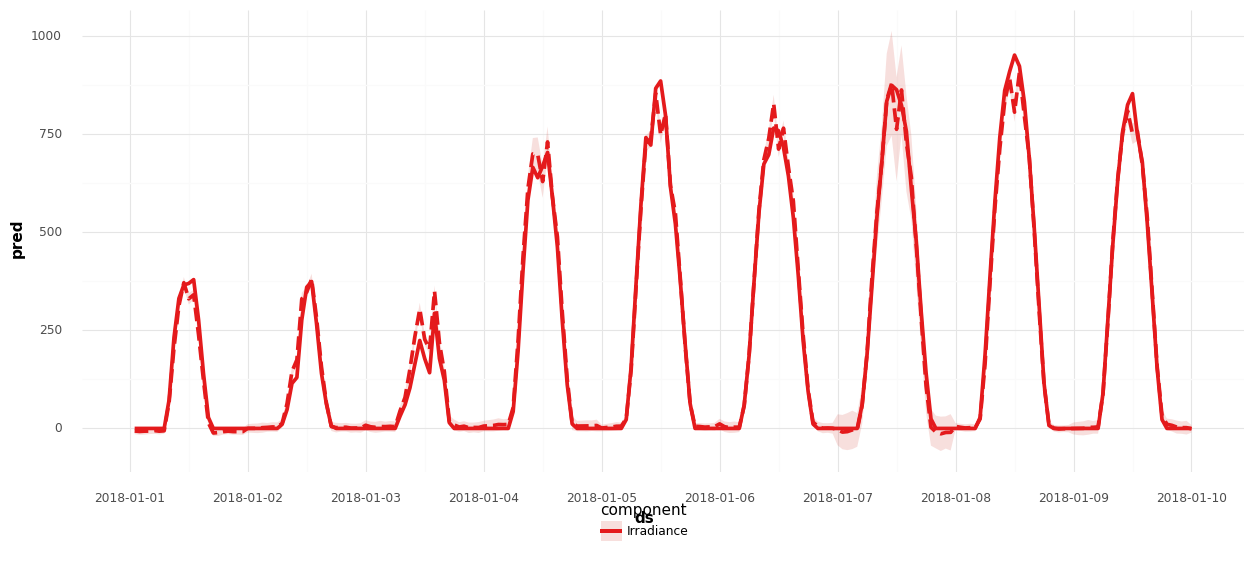

<ggplot: (8768909754688)>

In [10]:
start_day  = pd.Timestamp(2018, 1 ,1)
end_day = pd.Timestamp(2018, 1 ,10)

FCeVResults.plot_results(df["current"], df["5-12"], start_day, end_day)

In [151]:
df_pred_0 = df["current"]
df_pred_1 = df["5-12"]
df_pred_0 = df_pred_0[(df_pred_0.index > start_day) & (df_pred_0.index <= end_day)]
df_pred_1 = df_pred_1[(df_pred_1.index > start_day) & (df_pred_1.index <= end_day)]

pred_0 = pd.DataFrame(df_pred_0.mean(1), columns =  df_pred_0.columns.levels[-1])
pred_1 = pd.DataFrame(df_pred_1.mean(1), columns =  df_pred_1.columns.levels[-1])
label_forecast = ["pred_0", "pred_1"]
values_forecast = [pred_0, pred_1]
current_forecast = pd.concat(values_forecast,  keys = label_forecast, axis= 1)
current_forecast.columns = current_forecast.columns.set_names("component", level = 1)
current_forecast = current_forecast.stack(level=1).reset_index(1)

In [152]:
current_forecast

,component,pred_0,pred_1
ds,,,
2018-01-01 01:00:00,Irradiance,0.0,-6.519897
2018-01-01 02:00:00,Irradiance,0.0,-7.656129
2018-01-01 03:00:00,Irradiance,0.0,-6.923981
2018-01-01 04:00:00,Irradiance,0.0,-6.665078
2018-01-01 05:00:00,Irradiance,0.0,-5.458799
...,...,...,...
2018-01-09 20:00:00,Irradiance,0.0,7.929581
2018-01-09 21:00:00,Irradiance,0.0,3.446473
2018-01-09 22:00:00,Irradiance,0.0,2.066382


In [9]:
FCeVResults.plot_compare_results(df[["EMPTY"]], df[["5-12"]], start_day, end_day)

NameError: name 'start_day' is not defined

In [52]:
current = df_pred["EMPTY"].mean(1)
current.name = "components"
current

ds
2017-12-31 00:00:00     2.998880
2017-12-31 01:00:00     3.760233
2017-12-31 02:00:00     2.365927
2017-12-31 03:00:00     2.885628
2017-12-31 04:00:00     4.105904
                         ...    
2020-09-25 19:00:00   -13.050584
2020-09-25 20:00:00   -12.177238
2020-09-25 21:00:00   -10.558577
2020-09-25 22:00:00    -9.949520
2020-09-25 23:00:00    -9.505412
Freq: H, Name: components, Length: 24000, dtype: float32

In [28]:
pd.options.plotting.backend = "plotly" 
df_result.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '72c0890f-c195-40cc-9cca-59a4333140cf',
              'x': array([datetime.datetime(2017, 12, 31, 11, 30),
                          datetime.datetime(2018, 1, 1, 11, 30),
                          datetime.datetime(2018, 1, 2, 11, 30), ...,
                          datetime.datetime(2020, 9, 23, 11, 30),
                          datetime.datetime(2020, 9, 24, 11, 30),
                          datetime.datetime(2020, 9, 25, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([0.28931916, 0.17456265, 0.27465072, ..., 0.15878446, 0.34951526,
                        

In [193]:
df_result.plot()

TypeError: Data frame columns is a pandas MultiIndex. pandas MultiIndex is not supported by plotly express at the moment.

In [185]:
pd.options.plotting.backend = "plotly" 
df_result.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0-12<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0-12',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0-12',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '445e254a-cab0-468f-b1d2-45497c34e9ab',
              'x': array([datetime.datetime(2017, 12, 31, 11, 30),
                          datetime.datetime(2018, 1, 1, 11, 30),
                          datetime.datetime(2018, 1, 2, 11, 30), ...,
                          datetime.datetime(2020, 9, 23, 11, 30),
                          datetime.datetime(2020, 9, 24, 11, 30),
                          datetime.datetime(2020, 9, 25, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([15.02651215, 16.78451729, 20.50943184, ..., 24.04513359, 46.68315125,
          

In [105]:
print(mean_of_cov)
mean_of_cov = mean_of_cov /  len(df_pred.groupby(level=0, axis = 1))
return (100 * mean_of_cov)

NameError: name 'mean_of_cov' is not defined

AttributeError: 'DataFrame' object has no attribute 'level'

In [56]:
current = df["BASE"].mean(1)
current = df["BASE"].mean(1)
base = df["0"].mean(1)
expected = FCeV_results_data["df_events"].loc[current.index] * 1000
pred_0 = df['3-4'].mean(1)
pred_1 = df['3-16'].mean(1)
rmse_0 = base.sub(current).pow(2)
rmse_1 = pred_0.sub(current).pow(2)
pd.concat([current, pred_0, pred_1, rmse_0,rmse_1, expected], axis = 1).plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> 0 <i style="color:#fc9944">~1D</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'b794b4b1-da54-4f68-89dd-8c2f3fa35b8f',
              'x': array([datetime.datetime(2017, 12, 31, 0, 0),
                          datetime.datetime(2017, 12, 31, 12, 0),
                          datetime.datetime(2018, 1, 1, 1, 0), ...,
                          datetime.datetime(2020, 9, 23, 22, 0),
                          datetime.datetime(2020, 9, 25, 12, 0),
                          datetime.datetime(2020, 9, 25, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([  0.75063872, 271.96057129,  

In [38]:
[df["BASE"].columns in list(FCeV_results_data["df_synthetics"].keys())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
synthethic_columnses = list(df.columns.levels[0])
synthethic_names = [name for name in synthethic_names if name not in ["BASE", "EMPTY"]]
synthetics_values = [df.mean().values[0] for df in FCeV_results_data["df_synthetics"].values()]
synthetic_events = pd.DataFrame(synthetics_values, index = synthethic_names, columns = FCeV_results_data["df_events"].columns)
input_length = FCeV_results_data["n_forecast"]
df_events = FCeV_results_data["df_events"]
df_input = FCeV_results_data["df_input"]
freq = FCeV_results_data["freq"]

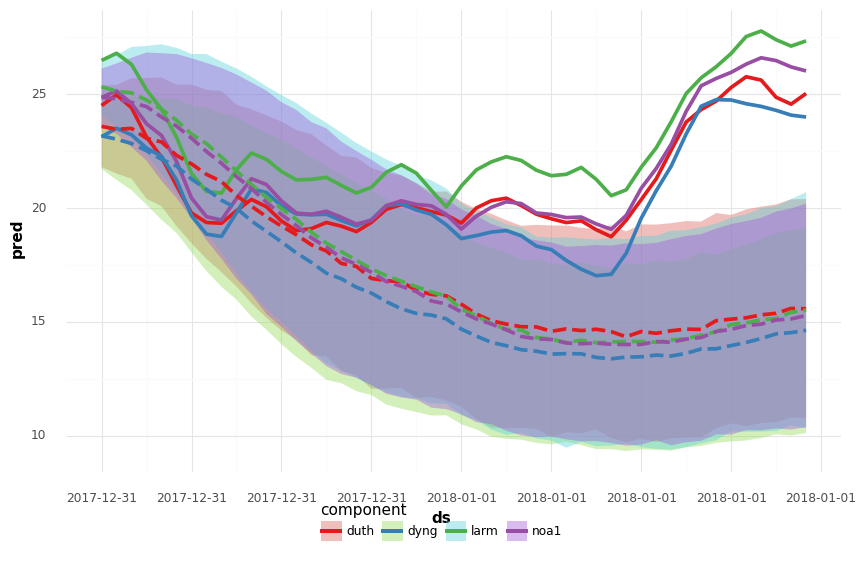

<ggplot: (8776079323989)>

In [17]:
from FCeV import METRICS
df1 = df["BASE"].head(48).copy()
pred = df1["pred"]
uncer = df1["uncer"]
current =df1["current"]
FCeVResults.plot_results(df1)

In [ ]:
scipy.stats.norm(pred[["larm"]],uncer[["larm"]] ).pdf(current[["larm"]])

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeVResults import SUMMARY_METRICS
from FCeV import METRICS
df_results = FCeVResults.predict_from_metrics(df, FCeV_results_data["df_events"], SUMMARY_METRICS.DTW, input_length, synthetic_events)
DTW = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"DTW: {DTW}")
df_results[[ "pred", "current"]].plot()

In [47]:
pd.options.plotting.backend = "plotly" 
from FCeVResults import SUMMARY_METRICS
from FCeV import METRICS
df_results = FCeVResults.predict_from_metrics(df, FCeV_results_data["df_events"], SUMMARY_METRICS.ZDENS, input_length, synthetic_events)
ZDENS = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
ZDENS_weigth = FCeV.get_metrics_from_fc(df_results[ "pred2"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"ZDENS: {ZDENS}")
print(f"ZSCORE_weigth Total: {ZDENS_weigth}")
df_results[[ "pred","pred2", "current"]].plot()

ZDENS: 1.5485407151609665
ZSCORE_weigth Total: 1.5980434631170106


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=pred<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'pred',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'pred',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '141f834e-7b2a-4c84-a828-606d5e617df2',
              'x': array([datetime.datetime(2017, 12, 31, 23, 30),
                          datetime.datetime(2018, 1, 1, 23, 30),
                          datetime.datetime(2018, 1, 2, 23, 30), ...,
                          datetime.datetime(2020, 1, 31, 23, 30),
                          datetime.datetime(2020, 2, 1, 23, 30),
                          datetime.datetime(2020, 2, 3, 23, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([69., 67., 68., ..., 72., 71., 62.]),
              'yaxis': 'y'},
             {'h

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results_sigma = FCeVResults.predict_from_metrics(df, df_events, SUMMARY_METRICS.RMSE_sigma, input_length, synthetic_events)
RMSE_sigma = FCeV.get_metrics_from_fc(df_results_sigma[ "pred"], df_results_sigma[ "current"], METRICS.RMSE).mean() / 100
print(f"RMSE_sigma: {RMSE_sigma}")
df_results[[ "pred", "current"]].plot()

In [ ]:
df_tab = df_results_sigma.copy()
len_test = 200
df_test = df_tab.iloc[:len_test]
df_tab = df_tab.iloc[len_test + 1:]
from FCeV import METRICS
df_resultsai = FCeVResults.predict_with_tabai(df_tab, df_test, 0.7, layers = 1000)
RMSEai = current_fcev.get_metrics_from_fc(df_resultsai["current"], df_resultsai["pred_ai"], METRICS.RMSE).mean()/100
RMSE = FCeV.get_metrics_from_fc(df_resultsai[ "pred"], df_resultsai[ "current"], METRICS.RMSE).mean() / 100
print(f"RMSE: {RMSE}")
print(f"RMSEai: {RMSEai}")
df_resultsai[[ "pred","pred_ai", "current"]].plot()

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
input_length = 48
df_events
df_results = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.CoV, input_length, synthetic_events)
CoV = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"CoV: {CoV}")
df_results[[ "pred", "current"]].plot()

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.PRESS, input_length, synthetic_events)
PRESS = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"PRESS Total: {PRESS}")
df_results[[ "pred", "current"]].plot()

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.RMSE, input_length, synthetic_events)
RMSE  = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"RMSE Total: {RMSE}")
df_results[[ "pred", "current"]].plot()

In [39]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.ZSCORE, input_length, synthetic_events)
ZSCORE  = FCeV.get_metrics_from_fc(df_results[ "pred"], df_results[ "current"], METRICS.RMSE).mean() / 100
ZSCORE_weigth= FCeV.get_metrics_from_fc(df_results[ "pred2"], df_results[ "current"], METRICS.RMSE).mean() / 100
print(f"ZSCORE Total: {ZSCORE}")
print(f"ZSCORE_weigth Total: {ZSCORE_weigth}")
df_results[[ "pred","pred2", "current"]].plot()

ZSCORE Total: 2.4877910214993864
ZSCORE_weigth Total: 2.4877910214993864


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=pred<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'pred',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'pred',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '5252ffcb-900f-4f69-8716-3f766c119c67',
              'x': array([datetime.datetime(2017, 12, 31, 23, 30),
                          datetime.datetime(2018, 1, 1, 23, 30),
                          datetime.datetime(2018, 1, 2, 23, 30), ...,
                          datetime.datetime(2020, 1, 31, 23, 30),
                          datetime.datetime(2020, 2, 1, 23, 30),
                          datetime.datetime(2020, 2, 3, 23, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([69., 67., 68., ..., 71., 70., 70.]),
              'yaxis': 'y'},
             {'h

In [ ]:
df_results = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.RMSE, input_length, synthetic_events)

df_tab = df_results.copy()
len_test = 200
df_test = df_tab.iloc[:len_test]
df_tab = df_tab.iloc[len_test + 1:]

df_resultsai = FCeVResults.predict_with_tabai(df_tab, df_test, 0.7, layers = 1000)
RMSEai = current_fcev.get_metrics_from_fc(df_resultsai["current"], df_resultsai["pred_ai"], METRICS.RMSE).mean()/100
RMSE = FCeV.get_metrics_from_fc(df_resultsai[ "pred"], df_resultsai[ "current"], METRICS.RMSE).mean() / 100
print(f"RMSE: {RMSE}")
print(f"RMSEai: {RMSEai}")
df_resultsai[[ "pred","pred_ai", "current"]].plot()

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results_CosSim = FCeVResults.predict_from_metrics(df, df_events, FCeVResults.SUMMARY_METRICS.CosSim, input_length, synthetic_events)
CosSim = FCeV.get_metrics_from_fc(df_results_CosSim[ "pred"], df_results_CosSim[ "current"], METRICS.RMSE).mean() /100 
print(f"CosSim: {CosSim}")
df_results_CosSim[[ "pred", "current"]].plot()

In [ ]:
from FCeV import METRICS
df_tab = df_results_CosSim.copy()
len_test = 200
df_test = df_tab.iloc[:len_test]
df_tab = df_tab.iloc[len_test + 1:]

df_resultsai = FCeVResults.predict_with_tabai(df_tab, df_test, 0.3, layers = 1000)
CosSimai = current_fcev.get_metrics_from_fc(df_resultsai["pred_ai"], df_resultsai["current"], METRICS.RMSE).mean()/100
CosSim = FCeV.get_metrics_from_fc(df_resultsai[ "pred"], df_resultsai[ "current"], METRICS.RMSE).mean() / 100
print(f"CosSim: {CosSim}")
print(f"CosSimai: {CosSimai}")
df_resultsai[[ "pred","pred_ai", "current"]].plot()

In [ ]:
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
df_results = FCeV.predict_from_metrics(df, df_events, METRICS.ZSCORE, input_length, synthetic_events)


In [ ]:
from FCeV import METRICS
df_tab = df_results.copy()
len_test = 200
df_test = df_tab.iloc[:len_test]
df_tab = df_tab.iloc[len_test + 1:]

df_resultsai = FCeV.predict_with_tabai(df_tab, df_test, 0.3, layers = 1000)
zscoreai = current_fcev.get_metrics_from_fc(df_resultsai["current"], df_resultsai["pred_ai"], METRICS.RMSE).mean()/100
zscore = FCeV.get_metrics_from_fc(df_resultsai[ "pred"], df_resultsai[ "current"], METRICS.RMSE).mean() / 100
zscore_w = FCeV.get_metrics_from_fc(df_resultsai[ "pred2"], df_resultsai[ "current"], METRICS.RMSE).mean() / 100
print(f"ZSCORE: {zscore}")
print(f"ZSCORE- weight: {zscore_w}")
print(f"ZSCOREAI: {zscoreai}")
df_resultsai[[ "pred2", "pred","pred_ai", "current"]].plot()

In [ ]:
df_results[["pred","current"]].rolling(5, min_periods=1).mean().plot()

In [ ]:
read_df = df.copy()
from sklearn.ensemble import IsolationForest

In [ ]:
# import AnomalyExperiment and init the class
from pycaret.anomaly import AnomalyExperiment
exp = AnomalyExperiment()
# init setup on exp
exp.setup(input_df_selected, session_id = 123)

In [49]:
# create PyCaret anomaly detection model
import pycaret
exp_name = setup(data = input_df_selected)
iforest = create_model('iforest', fraction=0.00001)

NameError: name 'setup' is not defined

In [ ]:
iforest_results = assign_model(iforest)
iforest_results.head()

In [ ]:
df_truth.head()

In [ ]:
df["BASE"]["current"].head()

In [ ]:
unseen_predictions = predict_model(iforest, data=df["BASE"]["current"])
df_truth
unseen_predictions.head()

In [ ]:
from darts.ad import KMeansScorer, WassersteinScorer, CauchyNLLScorer
scorer = KMeansScorer(k=2, window=1)
df_train = df_input[df_input.index < df.index[1]]
scorer.fit(TimeSeries.from_dataframe(df_train))

In [ ]:
# import pycaret anomaly and init setup

unseen_predictions = predict_model(iforest, data=df["0_0"]["pred"])
unseen_predictions["Anomaly_Score"]

In [50]:
df_discard = df.copy()[:-48]
from pycaret.anomaly import *
df_train = df_input[df_input.index < df.index[1]]
s = setup(df_train, session_id = 123)
iforest = create_model('iforest', fraction=0.05)
iforest_results = assign_model(iforest)

,Description,Value
0,Session id,123
1,Original data shape,"(35065, 4)"
2,Transformed data shape,"(35065, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [74]:
list_anomalies = list()
for name, group in df.drop(["BASE", "EMPTY"], axis = 1).groupby(level='CF', axis = 1):
        pred = group[name]["pred"]
        current = group[name]["current"]
        uncer = group[name]["uncer"]
        value = 0 # np.random.normal(0, 1, 4)
        simulation = pred + value * uncer
        unseen_predictions = predict_model(iforest, data=simulation)
        curret_metrics = unseen_predictions[["Anomaly_Score"]]
        curret_metrics.columns = synthetic_events.loc[name].values
        list_anomalies.append(curret_metrics)
df_anomalies = pd.concat(list_anomalies, axis = 1)

In [72]:
df_anomalies.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=60.0<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '60.0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> 60.0 <i style="color:#fc9944">~18h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '5423e668-e427-472e-bf2f-c5393ddec0ad',
              'x': array([datetime.datetime(2017, 12, 31, 12, 0),
                          datetime.datetime(2017, 12, 31, 16, 0),
                          datetime.datetime(2018, 1, 1, 14, 0), ...,
                          datetime.datetime(2020, 2, 3, 12, 0),
                          datetime.datetime(2020, 2, 3, 17, 0),
                          datetime.datetime(2020, 2, 4, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.17313307, -0.037

In [88]:
df_results = pd.DataFrame()
for index in range(len(df_anomalies) // input_length):
    df_test = df_anomalies.iloc[index * input_length: (index + 1) * input_length ]
    start_index = df_test.index.mean().round(freq='s')
    expected = df_events.loc[df_test.index]
    df_out = pd.DataFrame([[df_test.idxmin(1).values[0], expected.mean().values[0]]], columns = ["pred", "current"], index = [start_index])
    df_results = pd.concat([df_results, df_out])

In [89]:
df_results.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=pred<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'pred',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'pred',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'e37f5f0e-56c6-4945-8c13-f82aada02df0',
              'x': array([datetime.datetime(2017, 12, 31, 23, 45),
                          datetime.datetime(2018, 1, 1, 23, 45),
                          datetime.datetime(2018, 1, 2, 23, 45), ...,
                          datetime.datetime(2020, 1, 31, 23, 45),
                          datetime.datetime(2020, 2, 1, 23, 45),
                          datetime.datetime(2020, 2, 3, 23, 45)], dtype=object),
              'xaxis': 'x',
              'y': array([73., 78., 73., ..., 68., 75., 71.]),
              'yaxis': 'y'},
             {'h

In [87]:
for index in range(len(df_discard) // input_length):
    df_test = df.iloc[index * input_length: (index + 1) * input_length ]
    group = df_test["BASE"]
    pred = group["pred"]
    current = group["current"]
    uncer = group["uncer"]
    value = 0 # np.random.normal(0, 1, 4)
    predictions = TimeSeries.from_dataframe(pred, fill_missing_dates=True, freq=freq)
    currents = TimeSeries.from_dataframe(pred, fill_missing_dates=True, freq=freq)
    anom_score = scorer.score(predictions)
    all_anom = pd.concat([all_anom, anom_score.pd_dataframe()])
anom_score.plot()

NameError: name 'scorer' is not defined

In [ ]:
for index in range(len(df_discard) // input_length):
    df_test = df.iloc[index * input_length: (index + 1) * input_length ]
    group = df_test["BASE"]
    pred = group["pred"]
    current = group["current"]
    uncer = group["uncer"]
    value = 0 # np.random.normal(0, 1, 4)
    predictions = TimeSeries.from_dataframe(pred, fill_missing_dates=True, freq=freq)
    currents = TimeSeries.from_dataframe(pred, fill_missing_dates=True, freq=freq)
    anom_score = scorer.score(predictions)
    all_anom = pd.concat([all_anom, anom_score.pd_dataframe()])
anom_score.plot()

In [ ]:
all_anom[-49:].plot()

In [ ]:
from pycaret.anomaly import *
from sklearn.datasets import load_breast_cancer
from darts.ad import KMeansScorer, WassersteinScorer, CauchyNLLScorer
def get_anom(df, df_input, rep, k, window):
    scorer = KMeansScorer(k=10, window=48)
    df_train = df_input[df_input.index < df.index[1]]
    scorer.fit(TimeSeries(ts_current_train))
    for name, group in df_test.drop(["BASE", "EMPTY"], axis = 1).groupby(level='CF', axis = 1):
            pred = group[name]["pred"]
            current = group[name]["current"]
            uncer = group[name]["uncer"]
            value = 0 # np.random.normal(0, 1, 4)
            simulation = pred + value * uncer
            curret_metrics = get_summary(current, simulation, metric, uncer).mean().mean()
            list_values.append(pd.DataFrame(curret_metrics, columns = synth.loc[name].values, index = [start_index]))
            
    input_df_selected = input_df[input_df.index < df.index[0]]
    all_anom_score = None
    for index in range(30):
        ts_current_val = TimeSeries.from_dataframe(current_df["current"])
        ts_pred_val = TimeSeries.from_dataframe(current_df["pred"])
        ts_current_train = current_fcev.FCeV_model.input_series.drop_after(ts_current_val.start_time())
        ts_current_all = ts_current_train.append(ts_current_val)
        ts_base_all = ts_base_train.append(ts_base_val)
        scorer = KMeansScorer(k=3, window=10)
        scorer.fit(ts_current_train)
        anom_score = scorer.score_from_prediction(ts_current_val, ts_base_val)
        if all_anom_score is None:
            all_anom_score = anom_score
        else:
            all_anom_score = all_anom_score.concatenate(anom_score, axis = "component")
            

In [ ]:

for index in range(len(df) // input_length):
        df_test = df.iloc[index * input_length: (index + 1) * input_length - 1]
        list_values = list()
        list_index = list()
        list_colums = list()
        start_index = df_test.index.mean().round(freq='s')
        expected = df_events.loc[df_test.index]
        for name, group in df_test.groupby(level='CF', axis = 1):
            pred = group[name]["pred"]
            current = group[name]["current"]
            uncer = group[name]["uncer"]
            value = 0 # np.random.normal(0, 1, 4)
            simulation = pred + value * uncer
            curret_metrics = get_summary(current, simulation, metric, uncer).mean().mean()
            list_values.append(pd.DataFrame(curret_metrics, columns = synth.loc[name].values, index = [start_index]))

In [ ]:
    if all_frames is None:
        all_frames = all_anom_score.mean(1)
    else:
        #print(f"end all {all_frames.end_time()} + start_new {all_anom_score.mean(1).start_time()}")
        all_frames = all_frames.append(all_anom_score.mean(1))

In [ ]:

df_results.plot.scatter(x = "current", y = "pred", alpha = 0.1, figsize = (10,5))

In [ ]:
pd.options.plotting.backend = 'matplotlib'
df_results[["pred", "current"]].plot.hist(by=["pred"], figsize = (10, 30), sharex=True);

In [ ]:
from darts.ad import KMeansScorer, WassersteinScorer, CauchyNLLScorer
def get_anom(df):
    df = df.sort_index()
    S = 48 * 100
    N = int(len(df)/S)
    frames = [ df.iloc[i*S:(i+1)*S].copy() for i in range(N+1) ]
    frames.pop()
    all_frames = None
    frames = [df]
    for current_df in frames: 
        all_anom_score = None
        for index in range(30):
            ts_current_val = TimeSeries.from_dataframe(current_df["current"])
            ts_pred_val = TimeSeries.from_dataframe(current_df["pred"])
            ts_current_train = current_fcev.FCeV_model.input_series.drop_after(ts_current_val.start_time())
            ts_current_all = ts_current_train.append(ts_current_val)
            ts_base_all = ts_base_train.append(ts_base_val)
            scorer = KMeansScorer(k=3, window=10)
            scorer.fit(ts_current_train)
            anom_score = scorer.score_from_prediction(ts_current_val, ts_base_val)
            if all_anom_score is None:
                all_anom_score = anom_score
            else:
                all_anom_score = all_anom_score.concatenate(anom_score, axis = "component")
        if all_frames is None:
            all_frames = all_anom_score.mean(1)
        else:
            #print(f"end all {all_frames.end_time()} + start_new {all_anom_score.mean(1).start_time()}")
            all_frames = all_frames.append(all_anom_score.mean(1))
    return all_frames.pd_dataframe()

In [ ]:
from FCeV import METRICS
metrics = {}
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = value
        current = df["current"]
        pred = df["pred"]
        current_value = current_fcev.get_metrics_from_fc(current, pred, METRICS.RMSE).mean().mean()
        metrics[f"{key}"] = current_value
    else:
        for key_inner, value_inner in value.items():
            current = value_inner["current"]
            pred = value_inner["pred"]
            current_value = current_fcev.get_metrics_from_fc(current, pred, METRICS.RMSE).mean().mean()
            metrics[f"{synthetic_events.iloc[int(key_inner)].item()}"] = current_value


In [ ]:
metrics

In [ ]:
pred_serie = None
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = pd.DataFrame(current_fcev.get_metrics_from_fc(value, METRICS.RMSE).mean(axis = 1))
        df.columns = [f"{key}"]
        if pred_serie is None:
            pred_serie = TimeSeries.from_dataframe(df)
        else:
            pred_serie = pred_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")
    else:
        for key_inner, value_inner in value.items():
            df = pd.DataFrame(current_fcev.get_metrics_from_fc(value_inner, METRICS.RMSE).mean(axis = 1))
            df.columns = [f"{key}_{key_inner}"]
            pred_serie = pred_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")

In [ ]:
anom_serie = None
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = value
        df = get_anom(df)
        df.columns = [f"{key}"]
        if anom_serie is None:
            anom_serie = TimeSeries.from_dataframe(df)
        else:
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")
    else:
        for key_inner, value_inner in value.items():
            df = get_anom(value_inner)
            df.columns = [f"{key}_{key_inner}"]
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")

In [ ]:
#val_events = current_fcev.FCeV_model.events.slice_intersect(anom_serie)["pr"]
#anom_serie = anom_serie.concatenate(val_events, axis= "component")

In [ ]:
synthetic_events

In [ ]:
next_slice = anom_serie
start_point = anom_serie.start_time()
chunks = list()
chunk_len = 48
total_len = len(anom_serie)
for index in range(total_len // chunk_len  - 1) :
    current_slice, next_slice = next_slice.split_before(chunk_len)
    start_point = current_slice.end_time()
    chunks.append(current_slice.pd_dataframe())

In [ ]:
from fastcore import foundation


## USING TAB FASTAI

In [ ]:
from fastai.tabular.all import *

In [ ]:

y_name = "current"
df_tab = df_results.drop("pred",axis = 1).copy()
df_test = df_tab.iloc[:200]
df_tab = df_tab.iloc[200+1:]

min_y = np.min(df_tab[y_name]) - 1
df_tab[y_name] = np.log(df_tab[y_name] - min_y)

len_train = int(len(df_tab) * 0.8)
df_train = df_tab.iloc[:len_train];
df_val = df_tab.iloc[len_train + 1:];
len_train

In [ ]:
splits = (L(range(len(df_train))), L(range(len(df_train) + 1, len(df_train) + len(df_val))))

In [ ]:
to = TabularPandas(df_tab, procs=[FillMissing, Normalize],
                   cont_names = list(df_tab.drop(y_name, axis = 1).columns.values),
                   y_block=RegressionBlock(),
                   y_names=y_name,
                   splits=splits)
dls = to.dataloaders(bs=200)

In [ ]:
max_log_y = np.max(df_tab[y_name])*1.2
y_range = torch.tensor([0, max_log_y]); y_range
tc = tabular_config(ps=[0.2, 0.1], embed_p=0.4, y_range=y_range)
learn = tabular_learner(dls, layers=[10,50],
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat())

tc = tabular_config(y_range=y_range)
learn = tabular_learner(dls,
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat()
                        )
learn.lr_find()

In [ ]:
current_df = df[:10]
vector = np.linspace(0, 3000, 36)
print(len(current_df.columns.levels[2]))
np.random.normal(0,1,len(current_df.columns.levels[0]) * len(current_df.columns.levels[2]))

In [ ]:
current_df =df
random_vector  = np.random.normal(0,1,dim_0  * dim_2)
pred = pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["pred"] 
uncer = pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["uncer"]
current  =   pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["current"]
error = (pred + (random_vector * uncer) - current).pow(2)

In [ ]:
error.mean(1, level= 0)

In [ ]:
pd.DataFrame(error.to_records(index=False)).to_numpy()

In [ ]:
current_df = df[:10]

In [ ]:

learn.fit_one_cycle(100)

In [ ]:
dl = learn.dls.test_dl(df_test)
raw_test_preds = learn.get_preds(dl=dl)
learn.validate(dl=dl)
test_preds = (np.exp(raw_test_preds[0])+ min_y).numpy().T[0]
df_test["new_pred"] = test_preds
pd.options.plotting.backend = "plotly" 
from FCeV import METRICS
print(current_fcev.get_metrics_from_fc(df_test.head(200)["current"], df_test.head(200)["new_pred"], METRICS.RMSE).mean()/100)
df_test[["current", "new_pred"]].plot()

## Using Pythorch Lightning

In [ ]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
from torch import nn
from torch.utils.data import Dataset ,DataLoader
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from torcheval.metrics import BinaryAccuracy
import torchmetrics
#df_input =  anom_serie.pd_dataframe().drop("BASE", axis = 1)
#df_input =  pred_serie.pd_dataframe().drop("BASE", axis = 1)
df_input = df
df_label =  df_events.loc[df_input.index]


dim_0 = len(df_input.columns.levels[0])
dim_1 = len(df_input.columns.levels[1])
dim_2 = len(df_input.columns.levels[2])
channels = (dim_0)

CLASSES = 2
input_length = 48
kernel_size = 16
channel_1 = 128
channel_2 = 64
internal_size = 32

In [ ]:
class CassavaModel(pl.LightningModule):
    def __init__(self,dropout):
        
      #image_size = 64
        super().__init__()
        self.cnv_1 = nn.Conv1d(channels,channel_1,kernel_size, padding='same')

        self.bn_1 = nn.BatchNorm1d(channel_1)
        self.mxpool = nn.MaxPool1d(2)
        
        self.cnv_2 = nn.Conv1d(channel_1,channel_2,kernel_size // 2, padding='same')
        self.bn_2 = nn.BatchNorm1d(channel_2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(input_length  * channel_2 // 4,internal_size)
        self.fc2 = nn.Linear(internal_size,internal_size)
        self.fc3 = nn.Linear(internal_size,1)
        self.softmax = nn.Softmax()
        self.accuracy = BinaryAccuracy()
        self.loss_fn = torch.nn.MSELoss()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        out = self.bn_1(self.dropout(self.relu(self.cnv_1(x))))
        out = self.mxpool(out)
        out = self.bn_2(self.dropout(self.relu(self.cnv_2(out))))
        out = self.flat(self.mxpool(out))
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)
        #out = self.sigmoid(out)
        return out

    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer

    def training_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        
        loss = self.loss_fn(out,label)
        self.log('train_loss', loss)
        return loss       

    def validation_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        loss = self.loss_fn(out,label) 
        self.log('valid_loss', loss,prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        preds = self(img)
        preds = self.trainer.datamodule.min_max_scaler_y.inverse_transform(preds.cpu())
        current  = self.trainer.datamodule.min_max_scaler_y.inverse_transform(y.cpu())
        return current, preds
    
    def test_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        
        loss = self.loss_fn(out,label)
        self.log('test_loss', loss)
        return loss       

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self,df_input, df_events, input_length, weigth_uncer):
        self.df_input = df_input
        self.df_events = df_events
        self.input_length = input_length
        self.weigth_uncer = weigth_uncer
        self.dim_0 = len(df_input.columns.levels[0])
        self.dim_1 = len(df_input.columns.levels[1])
        self.dim_2 = len(df_input.columns.levels[2])
    def __len__(self):
        return len(self.df_input) //  input_length
    
    def __getitem__(self,item):
        #index_selected = [item * input_length : ((item + 1) * input_length)]
        current_df = self.df_input[item * input_length : ((item + 1) * input_length)]
        random_vector  = np.random.normal(0,1,self.dim_0  * self.dim_2)
        pred = pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["pred"] 
        uncer = pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["uncer"]
        current  =   pd.DataFrame(current_df.swaplevel(i = 0, j = 1, axis = 1))["current"]
        error = 0.01 +  ((pred + (self.weigth_uncer * random_vector * uncer))- current).mean(1, level = 0).pow(2).pow(1/2) 
        x = preprocessing.MinMaxScaler().fit_transform(error.values)
        #x = pd.DataFrame(error.to_records(index=False)).to_numpy()
        y = self.df_events[item * input_length : ((item + 1) * input_length)].mean()
        return {
            "x":torch.tensor(x,dtype=torch.float),
            "y":torch.tensor(y,dtype=torch.float),
        } 

In [ ]:
class CassavaLightDataset(pl.LightningDataModule):
    def __init__(self,df_input, df_label,input_length, test_part, batch_size=100):
        super().__init__()
        self.batch_size = batch_size
            
        self.min_max_scaler_y = preprocessing.MinMaxScaler()
        self.min_max_scaler_x = preprocessing.MinMaxScaler()
        self.df_input = df_input
        self.df_label = df_label
        self.test_part = test_part
        self.input_length = input_length


        
    def setup(self,stage=None):
        
        train_X,test_X, train_Y, test_Y  = train_test_split(self.df_input, self.df_label, test_size = self.test_part, shuffle = False)
        
        train_X_scaled = self.min_max_scaler_x.fit_transform(train_X.values)
        df_train_X_scaled = pd.DataFrame(train_X_scaled, columns = train_X.columns, index = train_X.index)
        
        train_X_scaled = train_X
        
        test_X_scaled = self.min_max_scaler_x.transform(test_X.values)
        self.test_X = pd.DataFrame(test_X_scaled, columns = test_X.columns, index = test_X.index)
        self.test_X = test_X
        
        ## LABEL TRAIN
        train_y_scaled = self.min_max_scaler_y.fit_transform(train_Y.values)
        df_train_y_scaled = pd.DataFrame(train_y_scaled, columns = train_Y.columns, index = train_Y.index)
        
        ## LABEL TEST
        test_y_scaled = self.min_max_scaler_y.transform(test_Y.values)
        self.test_Y = pd.DataFrame(test_y_scaled, columns = test_Y.columns, index = test_Y.index)
        
        self.train_X,self.val_X, self.train_Y, self.val_Y   = train_test_split(df_train_X_scaled,df_train_y_scaled, test_size = 0.1,shuffle = False)
        
        self.train_dataset = CassavaDataset(self.train_X, self.train_Y, self.input_length, 0)
        self.validation_dataset = CassavaDataset(self.val_X, self.val_Y, self.input_length,0)
        self.predict_dataset = CassavaDataset(self.test_X, self.test_Y, self.input_length,0)
    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset,
                            batch_size=self.batch_size, drop_last=True,
                            
                            shuffle=False)
        return train_loader
    def val_dataloader(self):
        valid_loader = DataLoader(self.validation_dataset,
                            batch_size=self.batch_size,drop_last=True,
                            shuffle=False) 
        return valid_loader
        
    def test_dataloader(self):
        test_loader = DataLoader(self.predict_dataset,
                            batch_size=self.batch_size,drop_last=True,
                            shuffle=False) 
        return test_loader
    def predict_dataloader(self):
        predict_loader = DataLoader(self.predict_dataset,
                            batch_size=len(self.predict_dataset),
                            shuffle=False)    
        return predict_loader

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_loss',
    dirpath='./',
    filename='models-{epoch:02d}-{valid_loss:.2f}',
    save_top_k=3,
    mode='min') 

mod = CassavaModel(0.3)
dx = CassavaLightDataset(df_input, df_label,48, 0.2,batch_size=50)
trainer = pl.Trainer(gpus=-1,max_epochs=100,callbacks=[checkpoint_callback])
trainer.fit(model=mod,datamodule=dx) 


In [ ]:
trainer.test(dataloaders=dx.train_dataloader(), ckpt_path="best")

In [ ]:
predictions = trainer.predict(mod, dataloaders=dx.train_dataloader(), ckpt_path="best")

In [ ]:
# (1) load the best checkpoint automatically (lightning tracks this for you)

predictions = trainer.test(datamodule = dx, ckpt_path="best")

In [ ]:
# test the model
predictions = trainer.predict(mod, dataloaders=dx.predict_dataloader(), ckpt_path="best")

In [ ]:
pd.DataFrame([predictions[0][0].flatten(), predictions[0][1].flatten()]).T.plot()

In [ ]:
predictions

In [ ]:
len(chunks)

In [ ]:
current_series

In [ ]:
anom_serie.columns = ["NO"]

In [ ]:
from darts import TimeSeries
current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)
    
iteration = 0
date_start = pd.Timestamp(2017, 1, 1)
current_fcev.create_folds(date_start, 12)
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)

In [ ]:
df_fore["SYNTH_0"].keys()




In [ ]:
df_main = df_fore["BASE"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_3 = df_fore["SYNTH_0"]["3"]
df_synth_5 = df_fore["SYNTH_0"]["5"]
df_synth_6 = df_fore["SYNTH_0"]["6"]
df_synth_8 = df_fore["SYNTH_0"]["8"]
df_real = current_fcev.FCeV_model.input_series.pd_dataframe()

In [ ]:
import matplotlib.pyplot as plt
df_main = df_fore["BASE"]
df_synth_0 = df_fore["SYNTH_0"]["0"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_2 = df_fore["SYNTH_0"]["2"]
#ts_base_val.plot()
(get_anom(df_main)).plot(label="No event", c="orangered", lw=3)
#(get_anom(df_real)).plot(label="Real", c="red", lw=3)
(get_anom(df_synth_0)).plot(label="0 days after", c="blue", lw=3)
(get_anom(df_synth_1)).plot(label="1 days after", c="green", lw=3)
(get_anom(df_synth_2)).plot(label="2 days after", c="cyan", lw=3)

In [ ]:
TimeSeries.from_dataframe(main_df["pred"])

In [ ]:
from FCeV import METRICS
main_df = df_fore["BASE"]
#second_df = df_fore["SYNTH_0"]["5"]
print(current_fcev.get_metrics_from_fc(main_df, METRICS.RMSE).mean().mean())
print(current_fcev.get_metrics_from_fc(second_df, METRICS.RMSE).mean().mean())

In [ ]:
main_df = df_fore["BASE"]

In [ ]:
main_df.stack(level=1).reset_index(1).columns

In [ ]:
second_df= main_df.stack(level=1).reset_index(1)

In [ ]:
second_df["uncer_min"] = second_df['pred'] - second_df['uncer']
second_df["uncer_max"] = second_df['pred'] + second_df['uncer']

second_df["uncer_min"] = second_df['pred'] 
second_df["uncer_max"] = second_df['pred']

In [ ]:
from plotnine import ggplot, aes, facet_grid, labs, geom_line,geom_point, theme, geom_ribbon,theme_minimal,scale_color_brewer
from plotnine_prism import *
(
    ggplot(second_df.reset_index())  # What data to use
    + aes(x="ds")  # What variable to use
    + geom_ribbon(aes(y = "pred", ymin = "uncer_min", ymax = "uncer_max", fill = "component"), alpha = .4) 
    + geom_line(aes(y="current", color = "component"),size = 1.5)  # Geometric object to use for drawing
    + geom_line(aes(y="pred", color = "component"),linetype="dashed",size = 1.5 )  # Geometric object to use for drawing
    + theme_minimal() 
    +theme(legend_position="bottom", figure_size=(18, 12))
    + scale_color_brewer(type="qual", palette="Set1")
)

In [ ]:
from FCeV import METRICS
current_fcev.get_metrics_from_fc(df_fore["BASE"], METRICS.RMSE).mean().mean()

In [ ]:
current_fcev.get_metrics_from_fc(df_fore["SYNTH_2"]["8"], METRICS.RMSE).mean().mean()

In [ ]:
df_fore["BASE"].plot()

In [ ]:
df_fore["SYNTH_5"]["24"].plot()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
train_day = dateutil.parser.parse("2018-09-30")
val_day = dateutil.parser.parse("2018-12-31")
series = TimeSeries.from_dataframe(df_ion[df_ion.index < val_day], fill_missing_dates=False, freq=freq)
series = series.astype(np.float32)
filler = MissingValuesFiller()
tec_series = filler.transform(series, method = "from_derivatives")

# Create training and validation sets:
train_tec, val_tec = tec_series.split_after(pd.Timestamp(train_day))

# We'll use the month as a covariate
scaler_tec = Scaler()
train_tec = scaler_tec.fit_transform(train_tec)
val_tec = scaler_tec.transform(val_tec)
tec_series = scaler_tec.transform(tec_series)



In [ ]:
widths = [4, 4, 3, 3, 6, 6, 6 ,6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 5, 7, 3, 4, 6, 4, 6, 5, 6, 6, 6, 9, 9, 9, 9, 3]
ion_data = pd.read_fwf('/home/carloscano/data/ion/ionosphere_parameters_data.txt', widths = widths, header=None)
id_ion = ["year", "doy", "hour", "id imf", "B scalar", "B vector", "Lat B", "Long B", "BY", "Bz", "SW Plasma Ta", "SW Proton", "SW Plasma Speed", "SW Plasma flow long", "SW Plasma Speed lat", "Alpha ratio", "Flow pressure", "Alfen", "Magneto", "Quasy", "Kp", "N sunspot", "Dst-index", "Ap index", "f107", "AE", "AL", "AU", "pc", "lyman", "Proton10", "Proton30", "Proton60", "Flux" ]
ion_data.columns = id_ion
strfmt = "{year}-{doy:0=3d}T{hour:0=2d}:00:00"

ion_data["datetime"] = ion_data.apply(lambda x: datetime.strptime(strfmt.format(year = int(x["year"]), doy = int(x["doy"]), hour = int(x["hour"])),"%Y-%jT%H:%M:%S"), axis = 1)

ion_data = ion_data.drop(["year", "doy", "hour"], axis = 1).set_index("datetime")

ion_data = ion_data[["Kp", "f107", "N sunspot"]]

In [ ]:
df_input

In [ ]:

ion_ts = TimeSeries.from_dataframe(ion_data[ion_data.index < val_day], fill_missing_dates=True, freq = "1H").resample(freq=freq)
ion_ts = ion_ts.astype(np.float32)
scaler_ion = Scaler()
ion_ts = scaler_ion.fit_transform(ion_ts)
# Create training and validation sets:
train_ion, val_ion = ion_ts.split_after(pd.Timestamp(train_day))

In [ ]:
my_model_TCN = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=48,
    n_epochs=40,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,
        pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },

)

my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Ion_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [ ]:
%%time

my_model_TCN.fit(
    train_tec,
    past_covariates=ion_ts,
    verbose=True,
)

In [ ]:
my_model_TCN.predict(100, past_covariates=ion_ts).plot()

In [ ]:
my_model_TCN.predict(10)

In [ ]:
from darts.ad import KMeansScorer,ForecastingAnomalyModel
scorer = KMeansScorer(k=5, window=20)

In [ ]:
ad_model = ForecastingAnomalyModel(my_model_TCN, scorer)
scorer.fit(train_tec)

In [ ]:
#anom_score = ad_model.score(val_tec,    past_covariates=ion_ts)

In [ ]:
%%time
ad_model.show_anomalies(val_tec,    past_covariates=ion_ts)

In [ ]:
train_tec.plot()

In [ ]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train_tec))
binary_anom = detector.detect(anom_score)

In [ ]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

In [ ]:
# Scale so that the largest value is 1.
# This way of scaling perserves the sMAPE
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [ ]:
for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    all_series_fp32[i].plot(label="{}".format(i, lw=1))

In [ ]:
from darts.explainability.shap_explainer import ShapExplainer
from darts.models import RegressionModel

In [ ]:
model = RegressionModel(lags=24, lags_future_covariates = [24,24], output_chunk_length = 24)
model.fit(train_tec, future_covariates=ion_ts)

## DALEX

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (25, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 48 * 5
forecast_horizon = 48
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=1000,
    n_epochs=2,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
            pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)


In [ ]:
my_model.fit(train_tec, future_covariates=ion_ts, verbose=True)

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


In [ ]:
eval_model(my_model, 48, tec_series, val_ion)

In [ ]:
forecast_horizon = 48
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

In [ ]:
eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon * 10,
    start=training_cutoff,
    transformer=transformer,
)

In [ ]:
my_model = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=24,
    n_epochs=2,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,

)

In [ ]:
def retrain_func(pred_time, train_series, past_covariates, future_covariates):
    print(len(past_covariates))
    return True

In [ ]:
backtest = model_air.historical_forecasts(
    series=tec_filled,
    past_covariates=ion_ts,
    start=0.90,
    forecast_horizon=1,
    retrain=False,
    verbose=False,
    last_points_only = False,
)

In [ ]:
def plot_backtest(ts_actual, ts_backtest):
    ts_actual[ts_backtest.time_index].plot(label="actual")
    ts_backtest.plot(label="backtest (H=6)")
    plt.legend()


In [ ]:
plot_backtest(tec_filled, backtest[5])

In [ ]:
len(filled)*0.01

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.datasets import AirPassengersDataset

In [ ]:
# Read data:
series = AirPassengersDataset().load()
series = series.astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [ ]:
my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)
my_model.fit(train_transformed, val_series=val_transformed)